In [223]:

#Imports
# import os
# os.environ['NUMEXPR_MAX_THREADS'] = 40
import numpy as np
import random
from time import time
from tmu.models.classification.vanilla_classifier import TMClassifier
from scipy.sparse import lil_matrix
from skimage.util import view_as_windows
from sklearn.feature_extraction.text import CountVectorizer
import cv2
from skimage.transform import pyramid_gaussian, pyramid_laplacian, downscale_local_mean
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt #drawing plots
import matplotlib.patches as patches #drawing squares
from matplotlib.lines import Line2D
from scipy.ndimage import rotate
import math 


import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix

from tqdm import tqdm #runtime stats

import ssl

ssl._create_default_https_context = ssl._create_unverified_context
from keras.datasets import cifar10


In [224]:

#Parameters

#TM
epochs = 50
max_included_literals = 10000
clauses = 10
T = int((np.sqrt(clauses)/2 + 2)*10)
s = 1.5
step = 1
visual_tokens = True
encode_to_hypervec = False

#Data
trained_labels = np.array([0,1,2,3])
#trained_labels = np.arange(4)
training_pool_size = 500 # number of testing pictures loaded

#preprocessing
resolution = 2 # scaled colors to thermometer code size of..
patch_dim = [3,3]

# Dice Dataset parameters
use_debug_dataset = True
train_size = training_pool_size
test_size = 300
window_top_left = (0, 0)
window_bottom_right = (32, 32)
dice_size = 12    

# Second run parameters
bypass_anchor_selection = True
n_anchor_points = 3

        

12 8
9 24
15 21
8 16
9 14
20 10
12 22
22 11
12 12


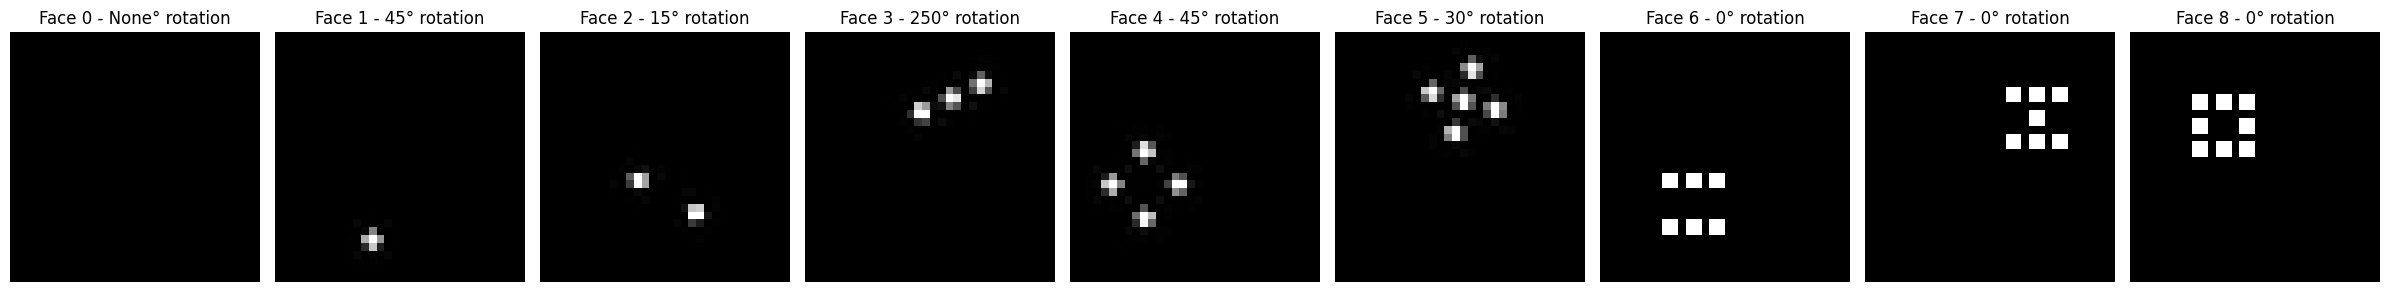

In [225]:
# Debug dataset creation function
def dice_image(value, top_left=(0, 0), bottom_right=(32, 32), dice_size=8, rand_placement=False, rotation_angle=None):
    img = np.zeros((32, 32, 3), dtype=np.uint8)
    
    # Relative dot size
    dot_size = dice_size // 6
    if dot_size<1:dot_size=1
    
    dot_color = (255, 0, 0)  # Red color
    dot_color = (255, 255, 255)  # Red color
    
    if value not in range(0, 10):
        raise ValueError("Dice value should be between 0 and 10.")

    
    # Relative positions for the center of dice based on its value and dice size
    offset = dice_size // 4
    positions = {
        1: [(-offset, -offset)],
        2: [(-offset, -offset), (offset, offset)],
        3: [(-offset, -offset), (0, 0), (offset, offset)],
        4: [(-offset, -offset), (-offset, offset), (offset, -offset), (offset, offset)],
        5: [(-offset, -offset), (-offset, offset), (offset, -offset), (offset, offset), (0, 0)],
        6: [(-offset, -offset), (-offset, offset), (offset, -offset), (offset, offset), (0, -offset), (0, offset)],
        7: [(-offset, -offset), (-offset, offset), (offset, -offset), (offset, offset), (0, 0), (0, -offset), (0, offset)],
        8: [(-offset, -offset), (-offset, offset), (offset, -offset), (offset, offset), (0, -offset), (0, offset), (-offset, 0), (offset, 0)],
        9: [(-offset, -offset), (-offset, offset), (offset, -offset), (offset, offset), (0, 0), (0, -offset), (0, offset), (-offset, 0), (offset, 0)]
    }
    if rand_placement:
        # Generate a random position within the window for the center of the dice
        center_x = random.randint(top_left[0] + dice_size // 2, bottom_right[0] - dice_size // 2)
        center_y = random.randint(top_left[1] + dice_size // 2, bottom_right[1] - dice_size // 2)
    else:
        center_y = bottom_right[1] - top_left[1]
        center_x = bottom_right[0] - top_left[0]
    if value != 0:
        for pos in positions[value]:
            x = center_x + pos[0]
            y = center_y + pos[1]
            img[y-dot_size//2:y+dot_size//2, x-dot_size//2:x+dot_size//2] = dot_color

    # Rotation logic
    if rotation_angle is not None:
        if rotation_angle in [90, 180, 270]:
            img = np.rot90(img, k=rotation_angle // 90)
        else:
            img = rotate(img, rotation_angle, reshape=False, mode='nearest')

    return img, center_x, center_y


# Testing the function
# Plotting the dice faces with random positions and rotations within the specified window
window_top_left = (0, 0)
window_bottom_right = (32, 32)
dice_size = 12
fig, axes = plt.subplots(1, 9, figsize=(24, 4))

rotations = [None, 45, 15, 250, 45, 30, 0, 0, 0 ,0]  # Some sample rotations

for ax, value, rot in zip(axes, range(0, 11), rotations):
    img, auxX, auxY = dice_image(value, window_top_left, window_bottom_right, dice_size, True, rot)
    ax.imshow(img)
    print(auxX, auxY)
    ax.axis("off")
    ax.set_title(f"Face {value} - {rot}° rotation")

plt.tight_layout()
plt.show()

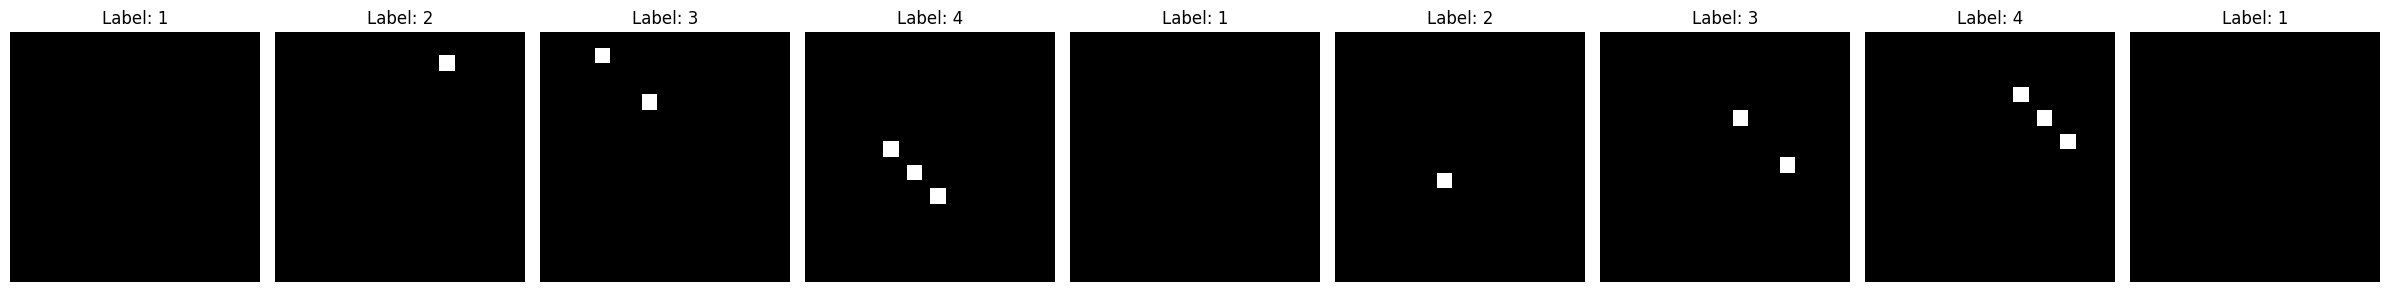

(500, 32, 32, 3)
(500,)
(300, 32, 32, 3)
(300,)


In [226]:
if use_debug_dataset: # Dataset selection
    def generate_debug_dataset(dataset_size, window_top_left, window_bottom_right, dice_size, random_rotations=False, include_random_class=False, random_placement=False):
        dataset = np.zeros((dataset_size, 32, 32, 3), dtype=np.uint8)
        labels = np.zeros((dataset_size,), dtype=np.uint8)
        dice_coordinates = np.zeros((dataset_size,2), dtype=np.uint8)
        
        #rotations = [None, 90, 180, 270]
        rotations = [None, 90, 180, 270]
        if not random_rotations:
            rotations = [None]
        
        for i in range(dataset_size):
            dice_val = trained_labels[(i % len(trained_labels))]
            rot = random.choice(rotations)
            # If the random class is to be included and the current index is for the random class
            if include_random_class and dice_val == 10:
                # Create a random pixel image
                dataset[i] = np.random.randint(0, 256, (32, 32, 3), dtype=np.uint8)
                labels[i] = 10  # The label for the random class
            else:
                # Create a dice image
                dataset[i], dice_coordinates[i, 0], dice_coordinates[i, 1] = dice_image(value=dice_val, top_left=window_top_left, bottom_right=window_bottom_right, dice_size=dice_size, rotation_angle=rot, rand_placement=random_placement)
                labels[i] = dice_val  # Making labels 0-indexed
        
        return dataset, labels, dice_coordinates

    

    # Generate datasets
    X_train_org, Y_train_org, coors_train_org = generate_debug_dataset(train_size, window_top_left, window_bottom_right, dice_size, include_random_class=True, random_rotations=False, random_placement=True)
    X_test_org, Y_test_org, coors_test_org = generate_debug_dataset(test_size, window_top_left, window_bottom_right, dice_size, random_rotations=False, random_placement=True)

    # Display some sample images from the training set
    fig, axes = plt.subplots(1, 9, figsize=(24, 4))
    for i in range(9):
        ax = axes[i]
        ax.imshow(X_train_org[i])
        ax.axis("off")
        ax.set_title(f"Label: {Y_train_org[i]+1}")

    plt.tight_layout()
    plt.show()
    labels = ["Zero", "One", "Two", "Three", "Four", "Five", "Six", "Seven", "Eight", "Nine"]
    
else:

    #Load cifar10
    (X_train_org, Y_train_org), (X_test_org, Y_test_org) = cifar10.load_data()
    labels = ["Airplane", "Car", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"]


    #adjust to train pool size
    X_test_org = X_test_org[0:training_pool_size]
    Y_test_org = Y_test_org.reshape(Y_test_org.shape[0])[0:training_pool_size]
    X_train_org = X_train_org[0:training_pool_size]
    Y_train_org = Y_train_org.reshape(Y_train_org.shape[0])[0:training_pool_size]

    #filter only desired labels
    X_train_org = X_train_org[np.in1d(Y_train_org, trained_labels)]
    Y_train_org = Y_train_org[np.in1d(Y_train_org, trained_labels)]

X_test_org = X_test_org[np.in1d(Y_test_org, trained_labels)]
Y_test_org = Y_test_org[np.in1d(Y_test_org, trained_labels)]

print(X_train_org.shape)
print(Y_train_org.shape)
print(X_test_org.shape)
print(Y_test_org.shape)

In [227]:
# Thermometer Coding
def thermometer_encode(image, resolution=8, prevMin=0, prevMax=255):
    # Get the shape of the input image
    shape = image.shape
    
    # Initialize the thermometer encoded image array
    encoded_image = np.empty(shape + (resolution,), dtype=np.uint8)
    
    # Perform thermometer encoding
    scale_factor = (prevMax - prevMin) / (resolution + 1)
    for z in range(resolution):
        encoded_image[..., z] = image >= prevMin + (z + 1) * scale_factor
    
    return encoded_image

def thermometer_decode(encoded_image, resolution, toMin=0, toMax=255):
    # Sum along the last dimension and scale back to the original range
    scale_factor = (toMax - toMin) / (resolution + 1)
    decoded_image = toMin + np.sum(encoded_image, axis=-1) * scale_factor
    
    # Cast the decoded image to uint8 data type
    decoded_image = decoded_image.astype(np.uint8)
    
    return decoded_image


In [228]:
def test_ThermEncodeAndDecode(original_image, thermometer_encode, thermometer_decode, resolution):
    # Encode the original image
    encoded_image = thermometer_encode(original_image, resolution)
    print(encoded_image[0])
    # Decode the encoded image back to the original form
    decoded_image = thermometer_decode(encoded_image, resolution)

    # Visualization
    plt.figure(figsize=(20, 7))

    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(decoded_image)
    plt.title('Decoded Image')
    plt.axis('off')

    plt.tight_layout()
    plt.show()
# Call the test function
#test_ThermEncodeAndDecode(np.full((32,32,3),223), thermometer_encode, thermometer_decode, 8)


In [229]:
def reshape_and_pad_dataset(dataset, target_dim_count, max_sizes):
    """Reshape and pad the dataset to have the target number of dimensions and sizes."""
    reshaped_dataset = dataset
    # Add new dimensions if necessary
    while len(reshaped_dataset.shape) < target_dim_count:
        reshaped_dataset = np.expand_dims(reshaped_dataset, axis=-1)
    
    # Pad each dimension as necessary
    padding = [(0, max_sizes[i] - reshaped_dataset.shape[i]) for i in range(len(max_sizes))]
    padded_dataset = np.pad(reshaped_dataset, padding, mode='constant', constant_values=0)
    
    return padded_dataset

def create_windowed_dataset(*datasets, patch_dim):
    if len(datasets) == 0:
        raise ValueError("At least one dataset must be provided")

    # Determine the maximum number of dimensions and sizes among all datasets
    max_dims = max(len(dataset.shape) for dataset in datasets)
    max_sizes = [max([dataset.shape[i] if i < len(dataset.shape) else 1 for dataset in datasets]) for i in range(max_dims)]

    # Reshape and pad datasets to have the same number of dimensions and sizes
    reshaped_padded_datasets = [reshape_and_pad_dataset(dataset, max_dims, max_sizes) for dataset in datasets]

    # Validate the shapes of the datasets
    common_shape = reshaped_padded_datasets[0].shape[:3]
    for dataset in reshaped_padded_datasets:
        if dataset.shape[:3] != common_shape:
            raise ValueError(f"All datasets must have the same num_images, height, and width. Expected shape: {common_shape}, but got {dataset.shape[:3]}")

    # Concatenate all datasets along the last dimension
    concatenated_dataset = np.concatenate(reshaped_padded_datasets, axis=-1)

    # Calculate and create the windowed dataset
    num_images, height, width, *data_dims = concatenated_dataset.shape
    windowed_shape = (num_images, height - patch_dim[0] + 1, width - patch_dim[1] + 1, patch_dim[0] * patch_dim[1] * np.prod(data_dims))
    windowed_dataset = np.zeros(windowed_shape, dtype=concatenated_dataset.dtype)

    for i in range(num_images):
        for y in range(height - patch_dim[0] + 1):
            for x in range(width - patch_dim[1] + 1):
                patch = concatenated_dataset[i, y:y + patch_dim[0], x:x + patch_dim[1], :]
                windowed_dataset[i, y, x, :] = patch.reshape(-1)

    return windowed_dataset




In [230]:
#Create windows
X_train = create_windowed_dataset(thermometer_encode(X_train_org), patch_dim=patch_dim)
X_test = create_windowed_dataset(thermometer_encode(X_test_org), patch_dim=patch_dim)

Y_train = Y_train_org
Y_test  = Y_test_org


In [231]:
#Train the TM 1 and record results
#f = open("run_%.1f_%d_%d_%d_%d_%d.txt" % (s, clauses, T, step, visual_tokens), "w+")
logTrain = np.zeros((epochs, X_train.shape[0]), dtype=np.uint8)
logTest =  np.zeros((epochs, X_test.shape[0]),  dtype=np.uint8)

print("Training:")
training_data_labels = np.unique(Y_train)
print(training_data_labels.shape[0], "labels used:", training_data_labels)
print("Training pictures:", X_train.shape[0])

print("Testing:")
testing_data_labels = np.unique(Y_test)
print(testing_data_labels.shape[0], "labels used:", testing_data_labels)
print("Maximum achievable accuracy:", (100*(training_data_labels.shape[0]/testing_data_labels.shape[0])))
print("..adjusting") #see result_test_adj
print("Testing pictures:", X_test.shape[0])

for label in range(trained_labels.shape[0]):
        print("\nAccuracy over %d epochs:\n" % (epochs))

        tm = TMClassifier(clauses, T, s, max_included_literals=max_included_literals, patch_dim=(1,1), platform='CPU', weighted_clauses=True)
        
        for epoch in tqdm(range(epochs)):
                start_training = time()
                tm.fit(X_train, Y_train)
                stop_training = time()

                start_testing = time()
                result_test = 100*(tm.predict(X_test) == Y_test).mean()
                result_test_adj = 100*(result_test/ (100*(training_data_labels.shape[0]/testing_data_labels.shape[0])))
                logTest[epoch] = (tm.predict(X_test))*label
                stop_testing = time()

                result_train = 100*(tm.predict(X_train) == Y_train).mean()
                logTrain[epoch] = (tm.predict(X_train))*label

                #recall_and_precision(epoch)

                print("%d %d %.2f %.2f %.2f %.2f" % (label, epoch, result_test_adj, result_train, stop_training-start_training, stop_testing-start_testing))
                #print("%d %d %.2f %.2f %.2f %.2f" % (label, epoch, result_test_adj, result_train, stop_training-start_training, stop_testing-start_testing), file=f)
                #f.flush()
#f.close()



Training:
4 labels used: [0 1 2 3]
Training pictures: 500
Testing:
4 labels used: [0 1 2 3]
Maximum achievable accuracy: 100.0
..adjusting
Testing pictures: 300

Accuracy over 50 epochs:



  0%|          | 0/50 [00:00<?, ?it/s]

2023-12-18 17:12:04,347 - tmu.models.classification.base_classification - DEBUG - Initializing clause bank....


  2%|▏         | 1/50 [00:03<02:30,  3.07s/it]

0 0 49.67 50.60 0.36 1.02


  4%|▍         | 2/50 [00:05<02:19,  2.90s/it]

0 1 54.00 51.60 0.06 1.02


  6%|▌         | 3/50 [00:08<02:13,  2.85s/it]

0 2 59.33 58.80 0.06 1.02


  8%|▊         | 4/50 [00:11<02:10,  2.83s/it]

0 3 56.33 56.00 0.06 1.02


 10%|█         | 5/50 [00:14<02:06,  2.82s/it]

0 4 57.00 55.60 0.06 1.02


 12%|█▏        | 6/50 [00:17<02:03,  2.81s/it]

0 5 65.67 64.40 0.06 1.03


 14%|█▍        | 7/50 [00:19<02:00,  2.80s/it]

0 6 77.00 75.40 0.06 1.02


 16%|█▌        | 8/50 [00:22<01:57,  2.80s/it]

0 7 78.00 74.80 0.06 1.02


 18%|█▊        | 9/50 [00:25<01:54,  2.80s/it]

0 8 65.33 62.40 0.06 1.03


 20%|██        | 10/50 [00:28<01:51,  2.80s/it]

0 9 75.67 73.20 0.06 1.03


 22%|██▏       | 11/50 [00:30<01:49,  2.80s/it]

0 10 68.00 69.80 0.06 1.03


 24%|██▍       | 12/50 [00:33<01:46,  2.79s/it]

0 11 69.00 65.20 0.06 1.02


 26%|██▌       | 13/50 [00:36<01:43,  2.79s/it]

0 12 66.67 63.20 0.06 1.03


 28%|██▊       | 14/50 [00:39<01:40,  2.79s/it]

0 13 68.33 71.00 0.06 1.02


 30%|███       | 15/50 [00:42<01:37,  2.79s/it]

0 14 63.67 67.80 0.06 1.02


 32%|███▏      | 16/50 [00:44<01:34,  2.79s/it]

0 15 63.00 65.40 0.06 1.03


 34%|███▍      | 17/50 [00:47<01:32,  2.80s/it]

0 16 58.67 59.20 0.06 1.03


 36%|███▌      | 18/50 [00:50<01:29,  2.80s/it]

0 17 75.00 76.40 0.06 1.03


 38%|███▊      | 19/50 [00:53<01:26,  2.80s/it]

0 18 69.33 70.40 0.06 1.03


 40%|████      | 20/50 [00:56<01:24,  2.80s/it]

0 19 68.00 66.40 0.06 1.04


 42%|████▏     | 21/50 [00:58<01:21,  2.80s/it]

0 20 64.33 64.80 0.06 1.03


 44%|████▍     | 22/50 [01:01<01:18,  2.80s/it]

0 21 69.67 68.60 0.06 1.03


 46%|████▌     | 23/50 [01:04<01:15,  2.80s/it]

0 22 64.33 62.80 0.06 1.03


 48%|████▊     | 24/50 [01:07<01:12,  2.80s/it]

0 23 65.67 64.20 0.06 1.02


 50%|█████     | 25/50 [01:10<01:09,  2.80s/it]

0 24 83.33 79.80 0.06 1.02


 52%|█████▏    | 26/50 [01:12<01:07,  2.79s/it]

0 25 66.67 66.20 0.06 1.02


 54%|█████▍    | 27/50 [01:15<01:04,  2.79s/it]

0 26 69.67 73.40 0.06 1.02


 56%|█████▌    | 28/50 [01:18<01:01,  2.79s/it]

0 27 70.67 69.60 0.06 1.02


 58%|█████▊    | 29/50 [01:21<00:58,  2.79s/it]

0 28 60.67 62.00 0.06 1.03


 60%|██████    | 30/50 [01:24<00:55,  2.79s/it]

0 29 74.67 76.60 0.06 1.02


 62%|██████▏   | 31/50 [01:26<00:53,  2.79s/it]

0 30 60.67 62.40 0.06 1.03


 64%|██████▍   | 32/50 [01:29<00:50,  2.79s/it]

0 31 68.67 64.60 0.06 1.02


 66%|██████▌   | 33/50 [01:32<00:47,  2.79s/it]

0 32 77.00 76.60 0.06 1.02


 68%|██████▊   | 34/50 [01:35<00:44,  2.79s/it]

0 33 79.33 78.20 0.06 1.02


 70%|███████   | 35/50 [01:38<00:41,  2.79s/it]

0 34 67.00 64.20 0.06 1.02


 72%|███████▏  | 36/50 [01:40<00:39,  2.79s/it]

0 35 70.00 71.20 0.06 1.03


 74%|███████▍  | 37/50 [01:43<00:36,  2.79s/it]

0 36 75.00 70.40 0.06 1.03


 76%|███████▌  | 38/50 [01:46<00:33,  2.79s/it]

0 37 80.33 77.00 0.06 1.03


 78%|███████▊  | 39/50 [01:49<00:30,  2.79s/it]

0 38 79.67 77.40 0.06 1.03


 80%|████████  | 40/50 [01:52<00:27,  2.79s/it]

0 39 74.00 72.60 0.06 1.02


 82%|████████▏ | 41/50 [01:54<00:25,  2.79s/it]

0 40 67.00 65.80 0.06 1.02


 84%|████████▍ | 42/50 [01:57<00:22,  2.79s/it]

0 41 67.67 64.60 0.06 1.02


 86%|████████▌ | 43/50 [02:00<00:19,  2.79s/it]

0 42 72.67 74.20 0.06 1.02


 88%|████████▊ | 44/50 [02:03<00:16,  2.79s/it]

0 43 70.67 72.80 0.06 1.02


 90%|█████████ | 45/50 [02:05<00:13,  2.79s/it]

0 44 68.67 72.40 0.06 1.02


 92%|█████████▏| 46/50 [02:08<00:11,  2.79s/it]

0 45 73.33 76.40 0.06 1.02


 94%|█████████▍| 47/50 [02:11<00:08,  2.79s/it]

0 46 62.67 62.20 0.06 1.02


 96%|█████████▌| 48/50 [02:14<00:05,  2.79s/it]

0 47 63.33 62.40 0.06 1.02


 98%|█████████▊| 49/50 [02:17<00:02,  2.79s/it]

0 48 57.33 58.60 0.06 1.03


100%|██████████| 50/50 [02:19<00:00,  2.80s/it]


0 49 72.33 71.20 0.06 1.02

Accuracy over 50 epochs:



  0%|          | 0/50 [00:00<?, ?it/s]

2023-12-18 17:14:24,256 - tmu.models.classification.base_classification - DEBUG - Initializing clause bank....


  2%|▏         | 1/50 [00:03<02:29,  3.05s/it]

1 0 49.67 48.60 0.35 1.02


  4%|▍         | 2/50 [00:05<02:18,  2.89s/it]

1 1 66.00 66.80 0.06 1.02


  6%|▌         | 3/50 [00:08<02:13,  2.85s/it]

1 2 54.67 54.80 0.06 1.02


  8%|▊         | 4/50 [00:11<02:09,  2.82s/it]

1 3 67.33 70.80 0.06 1.02


 10%|█         | 5/50 [00:14<02:06,  2.81s/it]

1 4 80.00 79.00 0.06 1.02


 12%|█▏        | 6/50 [00:16<02:03,  2.80s/it]

1 5 81.67 80.00 0.06 1.02


 14%|█▍        | 7/50 [00:19<02:00,  2.80s/it]

1 6 85.00 81.80 0.06 1.02


 16%|█▌        | 8/50 [00:22<01:57,  2.79s/it]

1 7 73.33 75.40 0.06 1.02


 18%|█▊        | 9/50 [00:25<01:54,  2.79s/it]

1 8 78.00 77.20 0.06 1.02


 20%|██        | 10/50 [00:28<01:51,  2.79s/it]

1 9 75.67 78.00 0.06 1.02


 22%|██▏       | 11/50 [00:30<01:48,  2.79s/it]

1 10 76.33 77.40 0.06 1.03


 24%|██▍       | 12/50 [00:33<01:46,  2.79s/it]

1 11 74.00 75.40 0.06 1.03


 26%|██▌       | 13/50 [00:36<01:43,  2.79s/it]

1 12 79.00 82.20 0.06 1.03


 28%|██▊       | 14/50 [00:39<01:40,  2.79s/it]

1 13 79.00 83.20 0.06 1.03


 30%|███       | 15/50 [00:42<01:37,  2.79s/it]

1 14 83.00 82.80 0.06 1.03


 32%|███▏      | 16/50 [00:44<01:34,  2.79s/it]

1 15 80.33 82.80 0.06 1.03


 34%|███▍      | 17/50 [00:47<01:32,  2.79s/it]

1 16 84.33 84.40 0.06 1.03


 36%|███▌      | 18/50 [00:50<01:29,  2.79s/it]

1 17 81.67 83.20 0.06 1.03


 38%|███▊      | 19/50 [00:53<01:26,  2.79s/it]

1 18 83.33 86.40 0.06 1.03


 40%|████      | 20/50 [00:56<01:23,  2.79s/it]

1 19 77.00 80.80 0.06 1.03


 42%|████▏     | 21/50 [00:58<01:21,  2.79s/it]

1 20 85.00 85.40 0.06 1.03


 44%|████▍     | 22/50 [01:01<01:18,  2.79s/it]

1 21 88.33 89.20 0.06 1.02


 46%|████▌     | 23/50 [01:04<01:15,  2.79s/it]

1 22 82.33 85.40 0.06 1.03


 48%|████▊     | 24/50 [01:07<01:12,  2.79s/it]

1 23 78.00 80.20 0.06 1.02


 50%|█████     | 25/50 [01:10<01:09,  2.79s/it]

1 24 84.67 83.60 0.06 1.02


 52%|█████▏    | 26/50 [01:12<01:06,  2.79s/it]

1 25 86.00 89.20 0.06 1.02


 54%|█████▍    | 27/50 [01:15<01:04,  2.79s/it]

1 26 83.33 85.00 0.06 1.03


 56%|█████▌    | 28/50 [01:18<01:01,  2.79s/it]

1 27 76.00 78.40 0.06 1.02


 58%|█████▊    | 29/50 [01:21<00:58,  2.79s/it]

1 28 79.67 82.80 0.06 1.03


 60%|██████    | 30/50 [01:23<00:55,  2.79s/it]

1 29 83.00 86.20 0.06 1.03


 62%|██████▏   | 31/50 [01:26<00:53,  2.79s/it]

1 30 82.67 86.80 0.06 1.03


 64%|██████▍   | 32/50 [01:29<00:50,  2.79s/it]

1 31 79.67 83.00 0.06 1.03


 66%|██████▌   | 33/50 [01:32<00:47,  2.79s/it]

1 32 86.33 88.80 0.06 1.03


 68%|██████▊   | 34/50 [01:35<00:44,  2.79s/it]

1 33 75.67 78.00 0.06 1.03


 70%|███████   | 35/50 [01:37<00:41,  2.79s/it]

1 34 83.67 84.20 0.06 1.02


 72%|███████▏  | 36/50 [01:40<00:39,  2.79s/it]

1 35 87.00 86.40 0.06 1.03


 74%|███████▍  | 37/50 [01:43<00:36,  2.79s/it]

1 36 83.67 84.00 0.06 1.03


 76%|███████▌  | 38/50 [01:46<00:33,  2.79s/it]

1 37 81.67 84.60 0.06 1.03


 78%|███████▊  | 39/50 [01:49<00:30,  2.79s/it]

1 38 83.67 87.20 0.06 1.03


 80%|████████  | 40/50 [01:51<00:27,  2.80s/it]

1 39 83.67 86.40 0.06 1.03


 82%|████████▏ | 41/50 [01:54<00:25,  2.80s/it]

1 40 75.67 76.00 0.06 1.03


 84%|████████▍ | 42/50 [01:57<00:22,  2.80s/it]

1 41 79.33 79.80 0.06 1.02


 86%|████████▌ | 43/50 [02:00<00:19,  2.79s/it]

1 42 86.33 87.00 0.06 1.02


 88%|████████▊ | 44/50 [02:03<00:16,  2.79s/it]

1 43 85.33 85.40 0.06 1.03


 90%|█████████ | 45/50 [02:05<00:13,  2.79s/it]

1 44 85.00 86.80 0.06 1.02


 92%|█████████▏| 46/50 [02:08<00:11,  2.79s/it]

1 45 84.33 87.40 0.06 1.03


 94%|█████████▍| 47/50 [02:11<00:08,  2.79s/it]

1 46 70.00 68.80 0.06 1.03


 96%|█████████▌| 48/50 [02:14<00:05,  2.79s/it]

1 47 86.67 89.40 0.06 1.02


 98%|█████████▊| 49/50 [02:17<00:02,  2.79s/it]

1 48 82.67 83.40 0.06 1.03


100%|██████████| 50/50 [02:19<00:00,  2.80s/it]


1 49 83.33 82.60 0.06 1.03

Accuracy over 50 epochs:



  0%|          | 0/50 [00:00<?, ?it/s]

2023-12-18 17:16:44,132 - tmu.models.classification.base_classification - DEBUG - Initializing clause bank....


  2%|▏         | 1/50 [00:03<02:29,  3.05s/it]

2 0 64.33 62.40 0.34 1.01


  4%|▍         | 2/50 [00:05<02:18,  2.89s/it]

2 1 71.00 71.00 0.06 1.02


  6%|▌         | 3/50 [00:08<02:13,  2.84s/it]

2 2 87.33 84.80 0.06 1.02


  8%|▊         | 4/50 [00:11<02:09,  2.82s/it]

2 3 73.67 73.40 0.06 1.03


 10%|█         | 5/50 [00:14<02:06,  2.81s/it]

2 4 84.67 84.00 0.06 1.02


 12%|█▏        | 6/50 [00:16<02:03,  2.81s/it]

2 5 75.33 75.20 0.06 1.03


 14%|█▍        | 7/50 [00:19<02:00,  2.80s/it]

2 6 76.67 78.80 0.06 1.03


 16%|█▌        | 8/50 [00:22<01:57,  2.80s/it]

2 7 75.00 76.80 0.06 1.02


 18%|█▊        | 9/50 [00:25<01:54,  2.79s/it]

2 8 84.67 85.60 0.06 1.02


 20%|██        | 10/50 [00:28<01:51,  2.79s/it]

2 9 78.00 78.60 0.05 1.02


 22%|██▏       | 11/50 [00:30<01:48,  2.79s/it]

2 10 82.67 87.80 0.06 1.02


 24%|██▍       | 12/50 [00:33<01:46,  2.79s/it]

2 11 74.33 74.80 0.05 1.02


 26%|██▌       | 13/50 [00:36<01:43,  2.79s/it]

2 12 81.00 86.00 0.06 1.03


 28%|██▊       | 14/50 [00:39<01:40,  2.79s/it]

2 13 76.33 81.80 0.06 1.03


 30%|███       | 15/50 [00:42<01:37,  2.79s/it]

2 14 87.33 88.00 0.06 1.02


 32%|███▏      | 16/50 [00:44<01:34,  2.78s/it]

2 15 75.33 76.00 0.06 1.02


 34%|███▍      | 17/50 [00:47<01:31,  2.78s/it]

2 16 84.67 88.00 0.06 1.02


 36%|███▌      | 18/50 [00:50<01:29,  2.78s/it]

2 17 76.00 75.60 0.06 1.02


 38%|███▊      | 19/50 [00:53<01:26,  2.78s/it]

2 18 83.00 85.20 0.06 1.03


 40%|████      | 20/50 [00:55<01:23,  2.78s/it]

2 19 81.00 83.20 0.06 1.02


 42%|████▏     | 21/50 [00:58<01:20,  2.78s/it]

2 20 80.00 84.40 0.06 1.02


 44%|████▍     | 22/50 [01:01<01:17,  2.78s/it]

2 21 82.33 87.60 0.06 1.02


 46%|████▌     | 23/50 [01:04<01:15,  2.78s/it]

2 22 82.00 85.20 0.06 1.03


 48%|████▊     | 24/50 [01:07<01:12,  2.78s/it]

2 23 81.67 84.00 0.06 1.02


 50%|█████     | 25/50 [01:09<01:09,  2.78s/it]

2 24 84.33 87.80 0.06 1.02


 52%|█████▏    | 26/50 [01:12<01:06,  2.78s/it]

2 25 85.67 89.40 0.06 1.02


 54%|█████▍    | 27/50 [01:15<01:04,  2.78s/it]

2 26 86.33 89.20 0.06 1.02


 56%|█████▌    | 28/50 [01:18<01:01,  2.78s/it]

2 27 88.33 89.20 0.06 1.02


 58%|█████▊    | 29/50 [01:21<00:58,  2.78s/it]

2 28 88.67 90.60 0.06 1.02


 60%|██████    | 30/50 [01:23<00:55,  2.78s/it]

2 29 79.67 78.00 0.06 1.02


 62%|██████▏   | 31/50 [01:26<00:52,  2.78s/it]

2 30 75.00 75.00 0.06 1.02


 64%|██████▍   | 32/50 [01:29<00:50,  2.78s/it]

2 31 87.67 89.00 0.06 1.03


 66%|██████▌   | 33/50 [01:32<00:47,  2.78s/it]

2 32 84.33 84.80 0.06 1.02


 68%|██████▊   | 34/50 [01:34<00:44,  2.79s/it]

2 33 88.67 90.80 0.06 1.02


 70%|███████   | 35/50 [01:37<00:41,  2.78s/it]

2 34 88.67 90.40 0.06 1.02


 72%|███████▏  | 36/50 [01:40<00:38,  2.78s/it]

2 35 50.00 50.00 0.06 1.02


 74%|███████▍  | 37/50 [01:43<00:36,  2.78s/it]

2 36 87.33 90.40 0.06 1.02


 76%|███████▌  | 38/50 [01:46<00:33,  2.78s/it]

2 37 85.67 83.80 0.05 1.02


 78%|███████▊  | 39/50 [01:48<00:30,  2.78s/it]

2 38 90.00 90.60 0.06 1.02


 80%|████████  | 40/50 [01:51<00:27,  2.78s/it]

2 39 81.33 82.60 0.05 1.02


 82%|████████▏ | 41/50 [01:54<00:25,  2.78s/it]

2 40 77.67 79.60 0.05 1.02


 84%|████████▍ | 42/50 [01:57<00:22,  2.78s/it]

2 41 88.33 89.80 0.06 1.02


 86%|████████▌ | 43/50 [01:59<00:19,  2.78s/it]

2 42 88.67 91.40 0.05 1.02


 88%|████████▊ | 44/50 [02:02<00:16,  2.78s/it]

2 43 89.00 89.00 0.06 1.02


 90%|█████████ | 45/50 [02:05<00:13,  2.78s/it]

2 44 90.67 91.00 0.06 1.02


 92%|█████████▏| 46/50 [02:08<00:11,  2.79s/it]

2 45 90.00 89.80 0.05 1.02


 94%|█████████▍| 47/50 [02:11<00:08,  2.79s/it]

2 46 88.00 89.00 0.06 1.03


 96%|█████████▌| 48/50 [02:13<00:05,  2.79s/it]

2 47 80.33 78.60 0.06 1.02


 98%|█████████▊| 49/50 [02:16<00:02,  2.79s/it]

2 48 81.67 82.20 0.06 1.02


100%|██████████| 50/50 [02:19<00:00,  2.79s/it]


2 49 87.67 89.20 0.06 1.02

Accuracy over 50 epochs:



  0%|          | 0/50 [00:00<?, ?it/s]

2023-12-18 17:19:03,633 - tmu.models.classification.base_classification - DEBUG - Initializing clause bank....


  2%|▏         | 1/50 [00:03<02:30,  3.07s/it]

3 0 56.00 52.20 0.35 1.02


  4%|▍         | 2/50 [00:05<02:19,  2.91s/it]

3 1 61.33 61.00 0.06 1.02


  6%|▌         | 3/50 [00:08<02:14,  2.86s/it]

3 2 63.67 63.20 0.06 1.03


  8%|▊         | 4/50 [00:11<02:10,  2.83s/it]

3 3 60.67 59.60 0.06 1.02


 10%|█         | 5/50 [00:14<02:06,  2.82s/it]

3 4 62.67 63.80 0.06 1.02


 12%|█▏        | 6/50 [00:17<02:03,  2.81s/it]

3 5 68.00 69.80 0.06 1.02


 14%|█▍        | 7/50 [00:19<02:00,  2.80s/it]

3 6 72.33 70.40 0.06 1.02


 16%|█▌        | 8/50 [00:22<01:57,  2.80s/it]

3 7 65.33 66.40 0.06 1.02


 18%|█▊        | 9/50 [00:25<01:54,  2.79s/it]

3 8 63.33 63.00 0.06 1.02


 20%|██        | 10/50 [00:28<01:51,  2.79s/it]

3 9 73.00 72.00 0.06 1.02


 22%|██▏       | 11/50 [00:30<01:48,  2.79s/it]

3 10 61.33 61.20 0.06 1.02


 24%|██▍       | 12/50 [00:33<01:46,  2.79s/it]

3 11 58.67 58.40 0.06 1.03


 26%|██▌       | 13/50 [00:36<01:43,  2.79s/it]

3 12 54.33 53.40 0.06 1.02


 28%|██▊       | 14/50 [00:39<01:40,  2.79s/it]

3 13 73.67 73.20 0.06 1.03


 30%|███       | 15/50 [00:42<01:37,  2.79s/it]

3 14 68.67 69.80 0.06 1.03


 32%|███▏      | 16/50 [00:44<01:34,  2.79s/it]

3 15 60.33 56.20 0.06 1.02


 34%|███▍      | 17/50 [00:47<01:32,  2.79s/it]

3 16 66.00 68.00 0.06 1.02


 36%|███▌      | 18/50 [00:50<01:29,  2.79s/it]

3 17 74.33 71.80 0.06 1.02


 38%|███▊      | 19/50 [00:53<01:26,  2.80s/it]

3 18 73.33 72.40 0.06 1.03


 40%|████      | 20/50 [00:56<01:23,  2.80s/it]

3 19 69.33 71.00 0.06 1.03


 42%|████▏     | 21/50 [00:58<01:21,  2.80s/it]

3 20 70.67 73.40 0.06 1.03


 44%|████▍     | 22/50 [01:01<01:18,  2.80s/it]

3 21 70.33 71.60 0.06 1.03


 46%|████▌     | 23/50 [01:04<01:15,  2.80s/it]

3 22 76.00 73.80 0.06 1.03


 48%|████▊     | 24/50 [01:07<01:12,  2.79s/it]

3 23 68.33 68.60 0.06 1.02


 50%|█████     | 25/50 [01:10<01:09,  2.79s/it]

3 24 57.67 57.20 0.06 1.03


 52%|█████▏    | 26/50 [01:12<01:07,  2.80s/it]

3 25 66.33 66.60 0.06 1.03


 54%|█████▍    | 27/50 [01:15<01:04,  2.80s/it]

3 26 60.33 60.20 0.06 1.02


 56%|█████▌    | 28/50 [01:18<01:01,  2.79s/it]

3 27 64.00 64.00 0.06 1.02


 58%|█████▊    | 29/50 [01:21<00:58,  2.80s/it]

3 28 66.33 64.40 0.06 1.02


 60%|██████    | 30/50 [01:24<00:55,  2.80s/it]

3 29 75.00 74.20 0.06 1.03


 62%|██████▏   | 31/50 [01:26<00:53,  2.80s/it]

3 30 71.33 69.60 0.06 1.02


 64%|██████▍   | 32/50 [01:29<00:50,  2.79s/it]

3 31 56.33 54.80 0.06 1.02


 66%|██████▌   | 33/50 [01:32<00:47,  2.79s/it]

3 32 64.67 67.20 0.06 1.03


 68%|██████▊   | 34/50 [01:35<00:44,  2.79s/it]

3 33 76.00 75.40 0.06 1.03


 70%|███████   | 35/50 [01:38<00:41,  2.79s/it]

3 34 71.00 70.80 0.06 1.02


 72%|███████▏  | 36/50 [01:40<00:39,  2.79s/it]

3 35 74.00 72.80 0.06 1.02


 74%|███████▍  | 37/50 [01:43<00:36,  2.79s/it]

3 36 66.67 66.00 0.06 1.03


 76%|███████▌  | 38/50 [01:46<00:33,  2.79s/it]

3 37 69.33 70.20 0.06 1.03


 78%|███████▊  | 39/50 [01:49<00:30,  2.80s/it]

3 38 73.33 72.00 0.06 1.02


 80%|████████  | 40/50 [01:52<00:27,  2.79s/it]

3 39 69.00 70.20 0.06 1.02


 82%|████████▏ | 41/50 [01:54<00:25,  2.79s/it]

3 40 63.67 60.60 0.06 1.02


 84%|████████▍ | 42/50 [01:57<00:22,  2.79s/it]

3 41 73.00 70.00 0.06 1.02


 86%|████████▌ | 43/50 [02:00<00:19,  2.79s/it]

3 42 55.00 56.00 0.06 1.02


 88%|████████▊ | 44/50 [02:03<00:16,  2.79s/it]

3 43 70.00 73.00 0.06 1.02


 90%|█████████ | 45/50 [02:05<00:13,  2.79s/it]

3 44 62.33 61.20 0.06 1.03


 92%|█████████▏| 46/50 [02:08<00:11,  2.79s/it]

3 45 73.33 72.40 0.06 1.03


 94%|█████████▍| 47/50 [02:11<00:08,  2.79s/it]

3 46 59.67 63.00 0.06 1.03


 96%|█████████▌| 48/50 [02:14<00:05,  2.79s/it]

3 47 68.33 69.80 0.06 1.03


 98%|█████████▊| 49/50 [02:17<00:02,  2.80s/it]

3 48 68.00 69.60 0.06 1.03


100%|██████████| 50/50 [02:19<00:00,  2.80s/it]

3 49 59.33 58.80 0.06 1.03


2023-12-18 17:21:24,243 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x2a3c5a650>


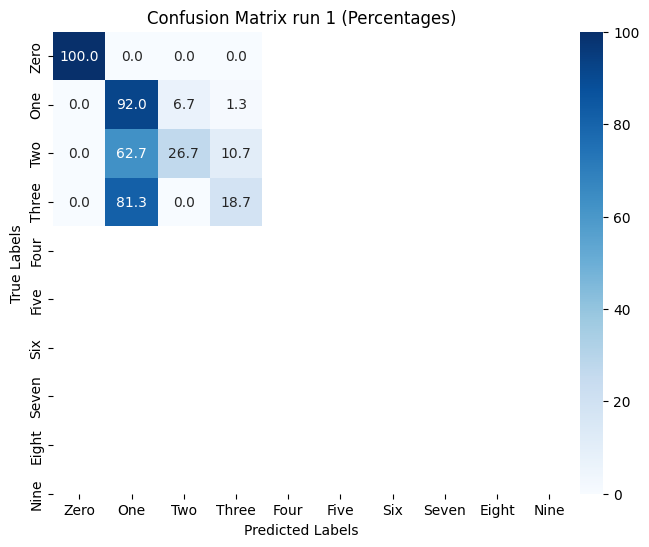

In [232]:
#Confusion Matrix
conf_matrix1 = confusion_matrix(Y_test, tm.predict(X_test))
# Calculate percentages
conf_matrix_percent1 = conf_matrix1 / conf_matrix1.sum(axis=1, keepdims=True) * 100
conf_matrix_percent1 = np.nan_to_num(conf_matrix_percent1, 0)  # Replace NaNs with 0

# Plot the confusion matrix with percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent1, annot=True, fmt=".1f", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix run 1 (Percentages)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [233]:
#Patch object

class Patch:
    def __init__(self, xMin, xMax, yMin, yMax, ID, patch_info, raw, weight=None):
        # Coordinates where patch appears
        self.xMin = xMin
        self.xMax = xMax
        self.yMin = yMin
        self.yMax = yMax
        
        self.weight = weight
        self.ID = ID
        self.patch_info = patch_info # color info in 3x3px 3xcolor uint8
        self.raw = raw #bool vals of whole clause
        self.found_in_images = {}
        self.total_count = 0
        self.sparsity = 0
            
    def visualize_patch_info(self, polarity=0):
        # Rescale the channel values to the range of 0-255
        patch_info_scaled = (np.array(self.patch_info) * (255 / resolution)).astype(np.uint8)
        
        # Create an empty image canvas
        image = np.zeros((3, 3, 3), dtype=np.uint8)
        # Loop through each channel
        for c in range(3):
            image[:,:,c] = patch_info_scaled[:,:,c, polarity].reshape((3,3))
        
        return image
    def dominant_color(self, value=0):
        # Reshape the patch to a 9x3 array
        pixels = self.patch_info[...,0].reshape((9, 3))

        # Calculate the sum of color values for each channel
        color_sums = np.sum(pixels, axis=0)

        # Find the index of the channel with the highest sum
        dominant_channel = np.argmax(color_sums)

        # Determine the dominant color based on the channel index
        if dominant_channel == 0:
            dominant_color = 'R'
        elif dominant_channel == 1:
            dominant_color = 'G'
        else:
            dominant_color = 'B'
        
        if value == 1:
            return dominant_channel
        elif value == 2:
            return sum(self.patch_info[:,:,dominant_channel]) // 3
        else:
            return dominant_color
        
    def update_patch_count(self, image_id, location):
        if image_id in self.found_in_images:
            self.found_in_images[image_id].append(location)
        else:
            self.found_in_images[image_id] = [location]
        self.total_count += 1
        


def thermometer_to_integer(thermometer_bits, negated = 0):
    value = 0
    thermometer_bits_local = thermometer_bits
    length = len(thermometer_bits_local)
    for bit in range(length):
        if not negated:
            if thermometer_bits_local[bit]:
                value = bit+1
        else:
            if thermometer_bits_local[bit]:
                value = bit
                break
            value = length+1
    return value

bank = tm.transform(X_train) # bank is a (image, clause*class) sized array

def transform_clause_to_patch(block, ID, resolution=8, patch_dim=(3,3), image_size=X_train_org.shape[1:3]):
    auxK = 0
    auxJ = image_size[0] - patch_dim[0] -1
    xMin = thermometer_to_integer(block[auxK:auxJ], negated=0)
    auxK = image_size[0] - patch_dim[0]
    auxJ = image_size[0] - patch_dim[0] + image_size[1] - patch_dim[1] -1
    yMin = thermometer_to_integer(block[auxK:auxJ], negated=0)
    auxK = image_size[0] - patch_dim[0] + image_size[1] - patch_dim[1] +patch_dim[0]*patch_dim[1]*resolution
    auxJ = image_size[0] - patch_dim[0] + image_size[1] - patch_dim[1] +patch_dim[0]*patch_dim[1]*resolution + image_size[0] - patch_dim[0] -1
    xMax = thermometer_to_integer(block[auxK:auxJ], negated=1)
    auxK = image_size[0] - patch_dim[0] + image_size[1] - patch_dim[1] +patch_dim[0]*patch_dim[1]*resolution + image_size[0] - patch_dim[0]
    auxJ = image_size[0] - patch_dim[0] + image_size[1] - patch_dim[1] +patch_dim[0]*patch_dim[1]*resolution + image_size[0] - patch_dim[0] + image_size[1] - patch_dim[1] -1
    yMax = thermometer_to_integer(block[auxK:auxJ], negated=1)
    
    # Sort out the pixels
    patch_info = np.zeros((3,3,3,2)) 
    for column in range(patch_dim[1]):
        # rows = []
        for row in range(patch_dim[0]):
            # colors = []
            for color in range(3):
                auxJ = image_size[0] - patch_dim[0] + image_size[1] - patch_dim[1] -1
                start_bit = auxJ + (column+row) * (3*resolution) + color * resolution
                end_bit = start_bit + resolution
                value = thermometer_to_integer(block[start_bit:end_bit])*(255/resolution)
                
                auxJ = image_size[0] - patch_dim[0] + image_size[1] - patch_dim[1] +patch_dim[0]*patch_dim[1]*resolution + image_size[0] - patch_dim[0] + image_size[1] - patch_dim[1] -1
                start_bit2 = auxJ + (column+row) * (3*resolution) + color * resolution
                end_bit2 = start_bit2 + resolution
                value2 = thermometer_to_integer(block[start_bit2:end_bit2], negated=1)*(255/resolution)
                #value = (value + value2)/2
                #if value == 0: # turn the pixel white if empty
                #    value = 8
                patch_info[column,row,color,0] = value
                patch_info[column,row,color,1] = value2
                # colors.append(value)
            # rows.append(colors)
        # patch_info.append(rows)
    raw = block
    weight = 0
    ID = ID
    return Patch(xMin=xMin, xMax=xMax, yMin=yMin, yMax=yMax, weight=weight, ID=ID, patch_info=patch_info, raw=raw)



Highlighting for image 3 of class Three
Class 0 Zero
Pro clauses for Class 0: [1, 2, 4]
Against clauses for Class 0: [5, 6, 8, 9]


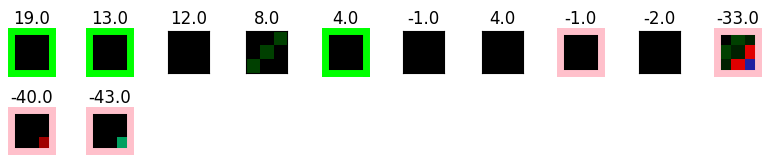

Class 1 One
Pro clauses for Class 1: [1, 2, 4, 10, 12, 13, 14]
Against clauses for Class 1: [5, 6, 8, 9, 16]


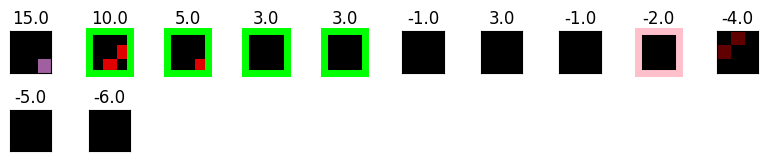

Class 2 Two
Pro clauses for Class 2: [1, 2, 4, 10, 12, 13, 14, 21, 22]
Against clauses for Class 2: [5, 6, 8, 9, 16, 25, 26, 27, 28, 29]


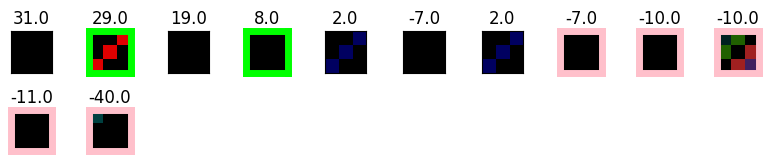

Class 3 Three
Pro clauses for Class 3: [1, 2, 4, 10, 12, 13, 14, 21, 22, 31, 32, 33]
Against clauses for Class 3: [5, 6, 8, 9, 16, 25, 26, 27, 28, 29, 35, 36, 37, 38, 39]


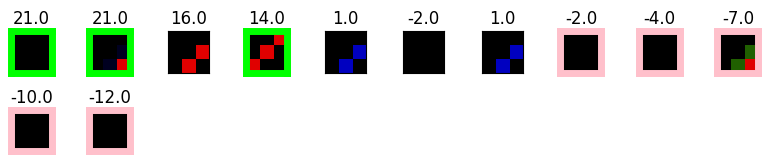

In [234]:
#Weighted Patches list, find extreme patches and plot them

#show how many patches
n_extreme_patches = 6
highlight_colors = {
    "for": "lime",
    "against": "pink"
}

highlight = True
check_image = 3

print("Highlighting for image", check_image, "of class", labels[Y_train_org[check_image]])

pro_clauses = []
against_clauses = []
all_patches = [] #class, clause

# Populate the patches list
k=0 # ID
for Class in range(tm.number_of_classes):
    class_patches = []
    for Clause in range(tm.number_of_clauses):
        block = [tm.get_ta_action(Clause, bit, Class) for bit in range(576)]
        class_patches.append(transform_clause_to_patch(block, k))
        k += 1
    all_patches.append(class_patches)

# Select top clauses
highest_indices = np.zeros((tm.number_of_classes, n_extreme_patches))
lowest_indices  = np.zeros((tm.number_of_classes, n_extreme_patches))
weights_sorted_indices = np.zeros((tm.number_of_classes, tm.number_of_clauses))
all_weights = np.zeros((tm.number_of_classes, tm.number_of_clauses))

for Class in range(tm.number_of_classes):
    for clause in range(tm.number_of_clauses):
        all_weights[Class, clause] = (tm.get_weight(the_class=Class,clause=clause,polarity=0))
    weights_sorted_indices[Class] = all_weights[Class].argsort()
    highest_indices[Class] = weights_sorted_indices[Class][-n_extreme_patches:].astype(int)
    lowest_indices[Class]  = weights_sorted_indices[Class][:n_extreme_patches].astype(int)

# Assign lowest and highest weighted patches to the indices  
extreme_patches = np.zeros((tm.number_of_classes,2,n_extreme_patches), dtype=Patch)
extreme_weights = np.zeros((tm.number_of_classes,2,n_extreme_patches), dtype=np.int16)
    
for Class in range(tm.number_of_classes):
    print("Class", Class, labels[Class])
    polarity = 0
    for i, k in enumerate(lowest_indices[Class].astype(int)):
        all_patches[Class][np.min((k, 997))].weight = all_weights[Class][np.min((k, 997))]
        extreme_patches[Class, polarity, i] = all_patches[Class][np.min((k, 997))]
        
    polarity = 1
    for i, k in enumerate(highest_indices[Class].astype(int)):
        all_patches[Class][k].weight = all_weights[Class][k]
        extreme_patches[Class, polarity, i] = all_patches[Class][k]


    extreme_patches = np.flip(extreme_patches,2)
    
    # Assign Pro and Against clauses per class
    for clause in range(int(tm.number_of_clauses/2)):  # First half for pro_clauses
        if bank[check_image][clause + Class * tm.number_of_clauses]:  # If the clause is activated
            pro_clauses.append(clause + Class * tm.number_of_clauses)
    for clause in range(int(tm.number_of_clauses/2), tm.number_of_clauses):  # Second half for against_clauses
        if bank[check_image][clause + Class * tm.number_of_clauses]:  # If the clause is activated
            against_clauses.append(clause + Class * tm.number_of_clauses)
    print(f"Pro clauses for Class {Class}: {pro_clauses}")
    print(f"Against clauses for Class {Class}: {against_clauses}")



    #Print patches grid
    num_rows = 10
    num_cols = 10

    fig = plt.figure(figsize=(8, 8))
    gs = GridSpec(num_rows, num_cols)
    adjusted_index = 0
    for patch_index in range(0, n_extreme_patches*2):
        if (patch_index >= n_extreme_patches): 
            polarity = 0
            adjusted_index = patch_index - n_extreme_patches
        else:
            adjusted_index = patch_index
            polarity = 1
        ax = fig.add_subplot(gs[patch_index // num_cols, patch_index % num_cols])
        ax.imshow(extreme_patches[Class, polarity, adjusted_index].visualize_patch_info())
        
        if highlight:
            # Highlight the randomly selected patches
            if polarity == 1 and extreme_patches[Class, polarity, adjusted_index].ID in pro_clauses:
                for spine in ax.spines.values():
                    spine.set_edgecolor(highlight_colors["for"])
                    spine.set_linewidth(5)
            elif polarity == 0 and extreme_patches[Class, polarity, adjusted_index].ID in against_clauses:
                for spine in ax.spines.values():
                    spine.set_edgecolor(highlight_colors["against"])
                    spine.set_linewidth(5)
            
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            ax.axis('off')
        ax.set_title((extreme_weights[Class][polarity][adjusted_index]).astype(str) + " " + (extreme_patches[Class, polarity, adjusted_index]).dominant_color())
        ax.set_title(extreme_patches[Class, polarity, adjusted_index].weight.astype(str))

    
    plt.tight_layout()
    plt.show()

In [235]:
def find_patches_in_image(image, patches_to_search, targeted_search=False, avg=True):
    """
    Search for specific patches within a given image. Return found ID and coordinates.
    
    Parameters:
    - image: 2D array representing the image.
    - patches_to_search: List of Patch objects to search for in the image.
    - targeted_search: Boolean indicating whether to search only within the patch's expected coordinates.
    - avg: Boolean indicating whether to return average coordinates for each patch.
    
    Returns:
    - results: Array with shape (number of patches, 3) containing the patch ID and its (average) x and y coordinates.
    - found_coordinates: List of tuples containing the coordinates where patches were found.
    """
    results = []
    for patch in patches_to_search:
        patch_info = patch.patch_info
        
        # Define the search area based on the targeted_search flag
        if targeted_search:
            search_area = image[patch.xMin:patch.xMax, patch.yMin:patch.yMax]
            offset_x, offset_y = patch.xMin, patch.yMin
        else:
            search_area = image
            offset_x, offset_y = 0, 0
        
        found_coordinates = []
        for x in range(search_area.shape[0] - patch_info.shape[0] + 1):
            for y in range(search_area.shape[1] - patch_info.shape[1] + 1):
                region = search_area[x:x+patch_info.shape[0], y:y+patch_info.shape[1]]
                if np.all(region >= patch_info[...,0]) and np.all(region <= patch_info[...,1]):
                    found_coordinates.append((x + offset_x, y + offset_y))
        
        # Calculate average coordinates if required
        if avg and found_coordinates:
            avg_x = int(np.mean([coord[0] for coord in found_coordinates]))
            avg_y = int(np.mean([coord[1] for coord in found_coordinates]))
            results.append((patch.ID, avg_x, avg_y))
        elif not avg:
            results.append((patch.ID, found_coordinates))
    
    return results


def find_patches_in_images(images, labels, patches_to_find):

    num_images = len(images)
    valid_indices = np.where((labels < patches_to_find.shape[0]) & (labels < num_images))[0]
    
    results = [find_patches_in_image(images[i], patches_to_find[labels[i], 0, :], targeted_search=True) for i in tqdm(valid_indices, desc="Processing images", position=0, leave=True)]
    
    return results  # Return the list of arrays directly


def create_dist_and_dir_map(images, Y_images, origin_points, n_origin_points=2):
    """
    Encode images based on the distance and angle to the origin patch.
    
    Parameters:
    - images: List of 2D arrays representing the images.
    - Y_images: List of labels corresponding to each image.
    - origin_points: List of origin points.[Class, img, coors[x,y]]
    - n_origin_points: Number of origin points to consider.
    
    Returns:
    - encoded_patches: Array containing the encoded images.
    """
    batch_size, height, width, _ = images.shape
    encoded_patches = np.zeros((batch_size, height, width, tm.number_of_classes, n_origin_points, 2))
    
    # if n_origin_points > 1:
    #     origin_coord = origins[img]
    # else:
    #     origin_coord = origins
    
    for img in range(batch_size):
        for j in range(height):
            for k in range(width):
                for Class in range(tm.number_of_classes):
                    for point in range(n_origin_points):
                        origin_coord = origin_points[Class][img]
                        # Check if the origin coordinate is a placeholder
                        if np.any(origin_coord == -1):
                            continue
                        else:
                            distance, angle = calculate_distance_and_direction(origin_coord, (j, k))
                            encoded_patches[img, j, k, Class, point] = [distance, angle]
    return encoded_patches
"""




    if not bypass_anchor_selection:
        for i in range(batch_size):
            class_label = Y_images[i, 0] if len(Y_images.shape) > 1 else Y_images[i] #TODO: sometimes its two dim array??
            if class_label < tm.number_of_classes:
                origins = origin_points[class_label]  # Adjusted to get origins for specific image and class
            else:
                encoded_patches[i] = np.zeros((height, width, 2 * n_origin_points))
                continue
            
            for point in range(n_origin_points):
                if n_origin_points > 1:
                    origin_coord = origins[i]
                else:
                    origin_coord = origins
                # Check if the origin coordinate is a placeholder
                if np.any(origin_coord == -1):
                    continue
                for j in range(height):
                    for k in range(width):
                        print("org cord", origin_coord)
                        distance, angle = calculate_distance_and_direction(origin_coord, (j, k))
                        encoded_patches[i, j, k, point*2:point*2+2] = [distance, angle]
            
    else:
              
        for i in range(batch_size):
            encoded_patches[i] = np.zeros((img, height, width, Class, n_origin_points, 2))
            continue
        
        for point in range(n_origin_points):
            if n_origin_points > 1:
                origin_coord = origins[i]
            else:
                origin_coord = origins
            # Check if the origin coordinate is a placeholder
            if np.any(origin_coord == -1):
                continue
            for j in range(height):
                for k in range(width):
                    print("org cord", origin_coord)
                    distance, angle = calculate_distance_and_direction(origin_coord, (j, k))
                    encoded_patches[i, j, k, Class, point] = [distance, angle]
            
    return encoded_patches
"""

def scale_value_int(value, old_max, new_max):
    return int((value / old_max) * new_max)


def calculate_distance_and_direction(coord1, coord2):
    #TODO: remove the koeficients and replace with variable adjusting. the scaling now is to fit 0 to 255 scale
    distance = 7* math.sqrt((coord2[0] - coord1[0])**2 + (coord2[1] - coord1[1])**2)
    angle = 80 * math.atan2(coord2[1] - coord1[1], coord2[0] - coord1[0])
    return distance, angle



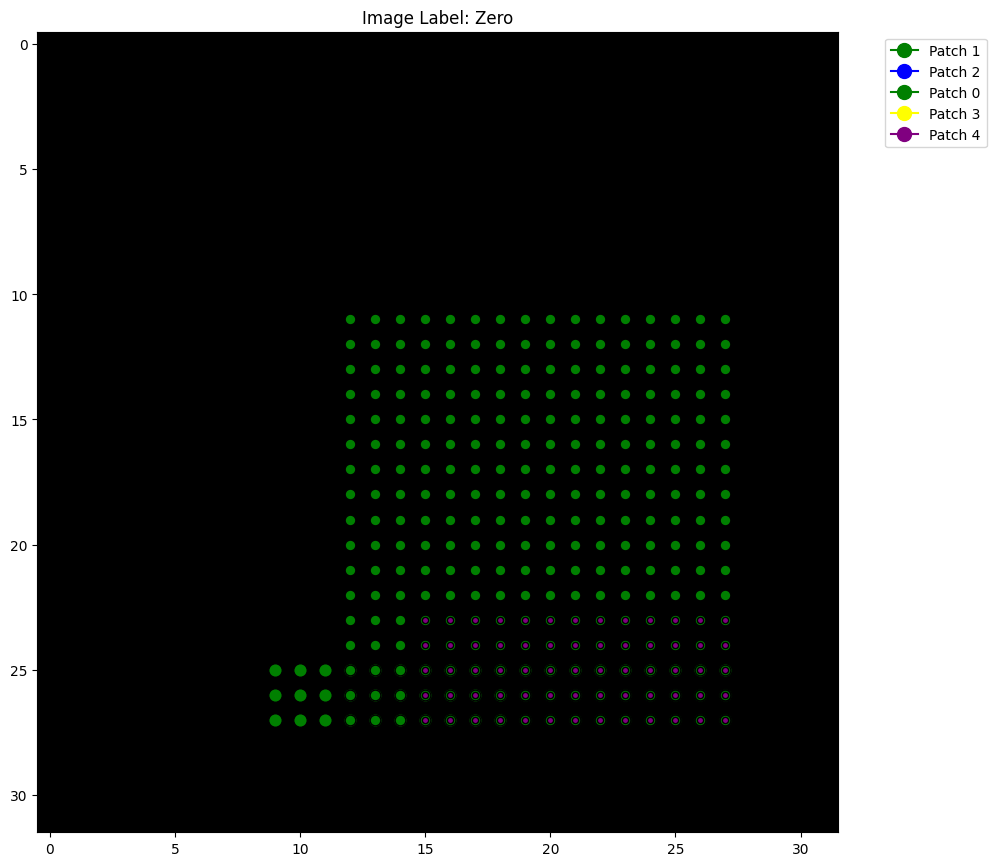

Minimum values of patches


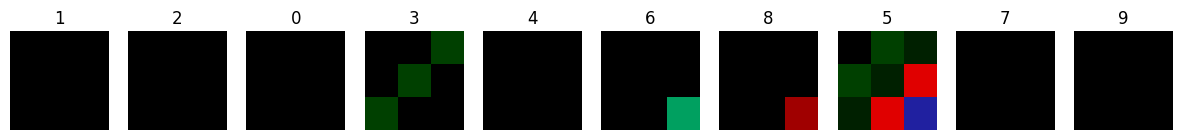

Maximum values of patches


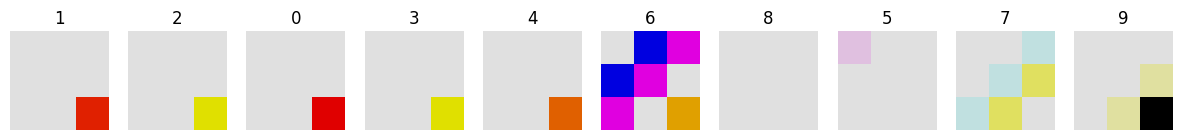

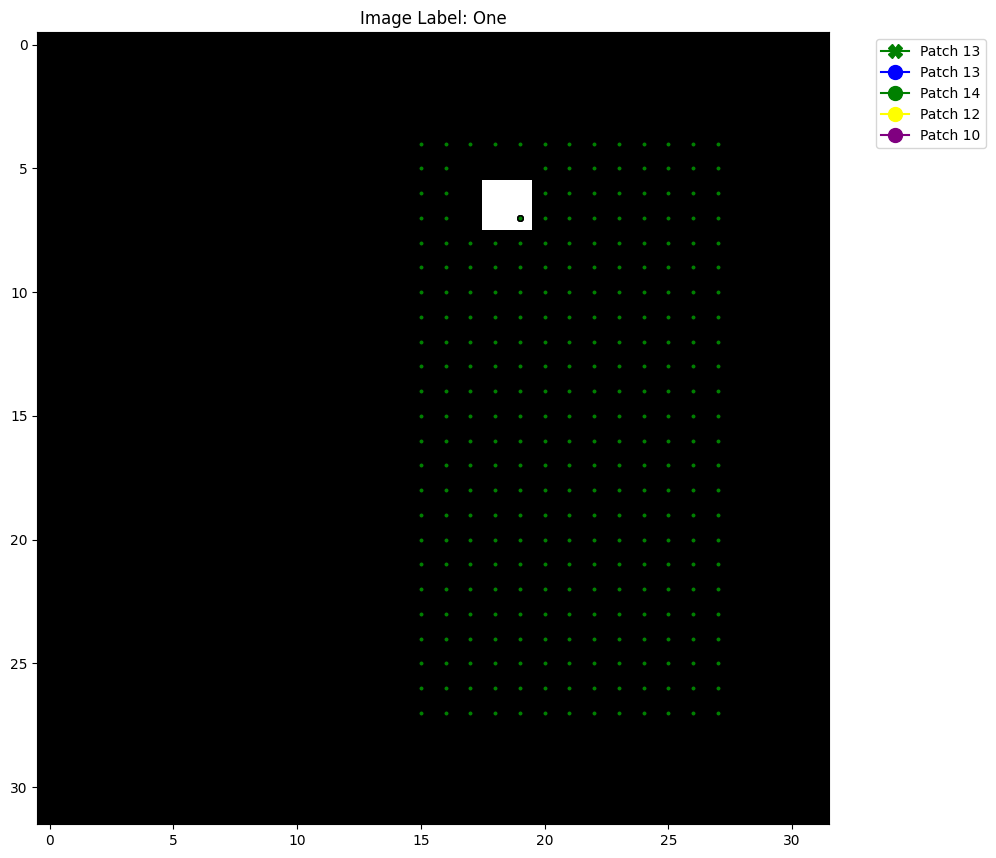

Minimum values of patches


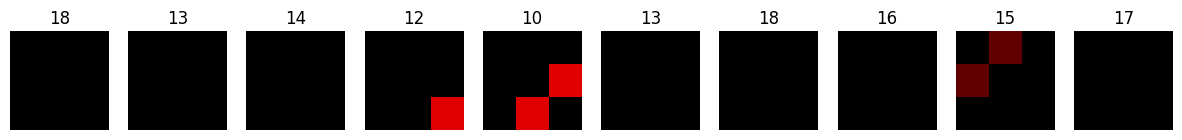

Maximum values of patches


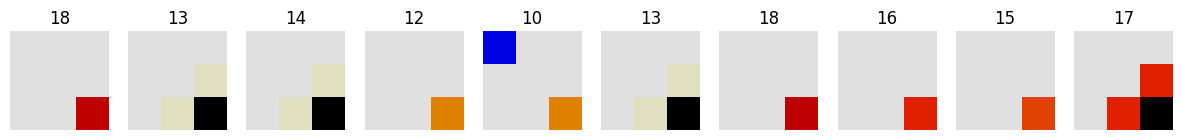

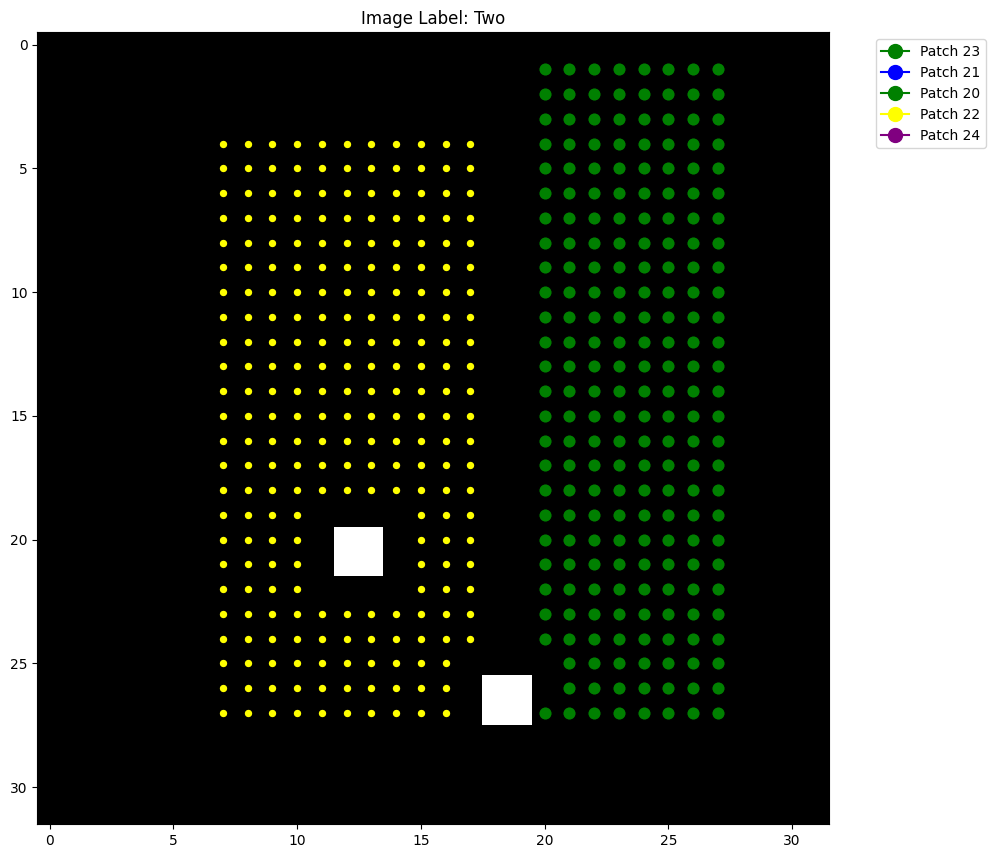

Minimum values of patches


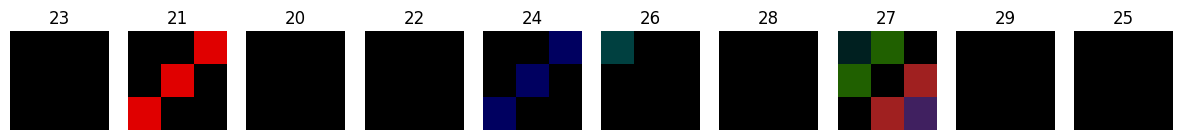

Maximum values of patches


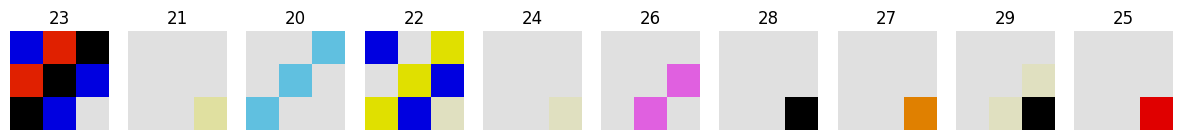

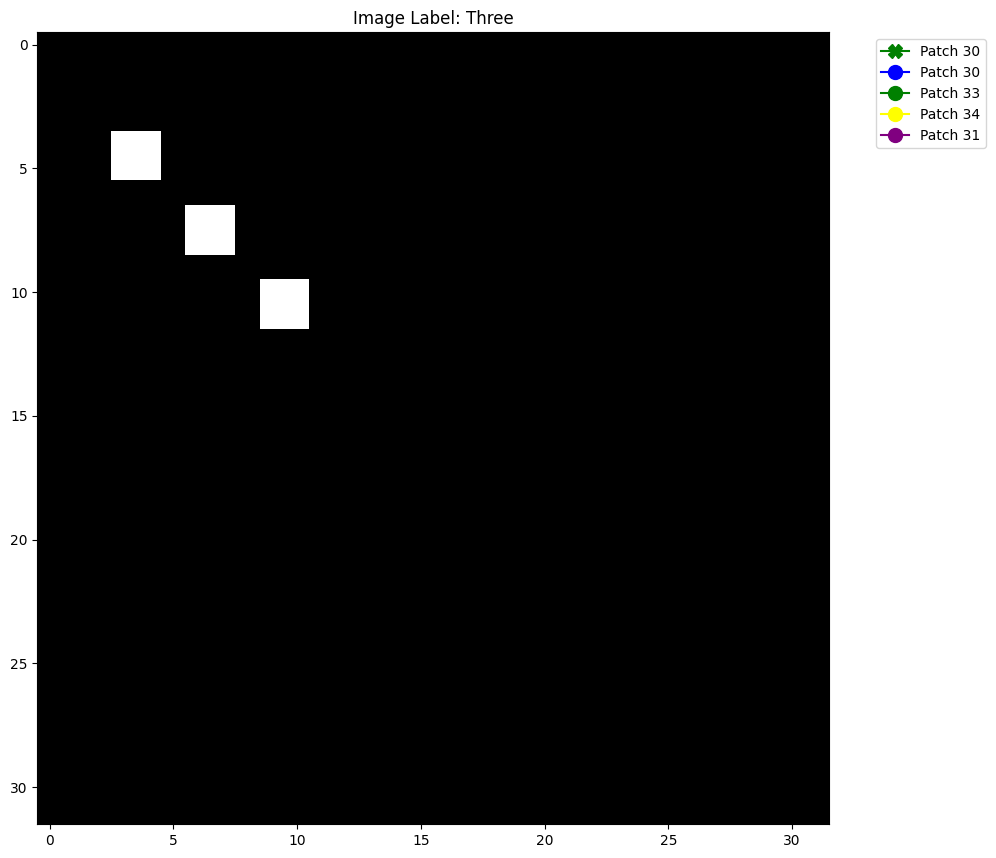

Minimum values of patches


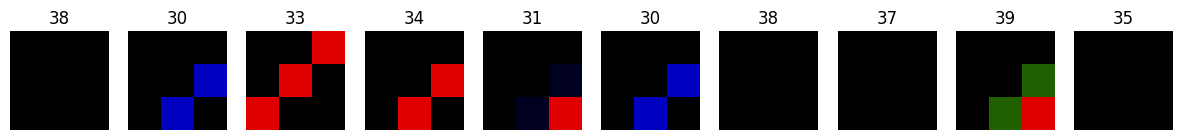

Maximum values of patches


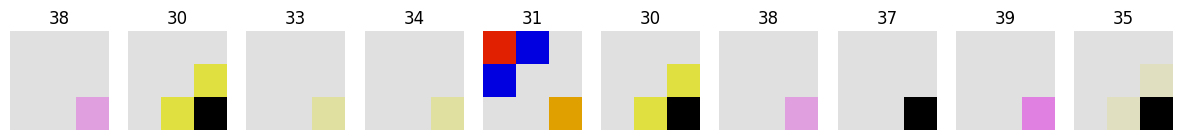

In [236]:
#Plot extreme patches on images

def plot_patches_in_images(patch_list_pos, patch_list_neg, images, image_labels):
    all_results = {}
    
    # Define a list of colors
    colors = ['green', 'blue', 'green', 'yellow', 'purple', 'orange', 'cyan', 'magenta', 'brown', 'pink']
    
    for img_index, (image, label) in enumerate(zip(images, image_labels)):
        results = []
        legend_elements = []  # List to hold the legend elements
        heatmaps = np.zeros_like(image, dtype=float)

        # Plot the main image with dots
        fig_main, ax_main = plt.subplots(figsize=(10, 10))
        ax_main.imshow(image, cmap='gray')
        ax_main.set_title(f'Image Label: {label}')

        for patch_idx, (patch_pos, patch_neg) in enumerate(zip(patch_list_pos, patch_list_neg)):
            patch = patch_pos if patch_pos.weight > 0 else patch_neg
            marker_style = 'o' if patch_pos.weight > 0 else 'X'
            
            # Use the new find_patches_in_image function
            patch_search_results = find_patches_in_image(image, [patch], targeted_search=True, avg=False)
            
            color = colors[patch_idx % len(colors)]
            for patch_id, patch_coords in patch_search_results:
                for coord in patch_coords:
                    # Plot the position with the chosen marker style
                    ax_main.scatter(coord[1]+1, coord[0]+1, color=color, s=abs(patch.weight*5), marker=marker_style, edgecolors='black', linewidths=1)
                    results.append((patch_id, coord[0], coord[1]))
            
            # Add a legend element for each patch
            legend_elements.append(Line2D([0], [0], marker=marker_style, color=color, label=f'Patch {patch.ID}', markersize=10, markerfacecolor=color, markeredgewidth=1))

        # Add the legend outside of the main plot
        ax_main.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

        print("Minimum values of patches")
        # Plot each patch in a separate figure
        fig_patches, axs = plt.subplots(1, len(patch_list_pos) + len(patch_list_neg), figsize=(15, 3))
        if len(patch_list_pos) + len(patch_list_neg) == 1:
            axs = [axs]

        for patch_idx, patch in enumerate(patch_list_pos + patch_list_neg):
            patch_image = patch.visualize_patch_info()  # Visualize the patch
            axs[patch_idx].imshow(patch_image)
            axs[patch_idx].set_title(f'{patch.ID}')
            axs[patch_idx].axis('off')  # Hide the axis

        plt.show()
        print("Maximum values of patches")
        # Plot each patch in a separate figure
        fig_patches, axs = plt.subplots(1, len(patch_list_pos) + len(patch_list_neg), figsize=(15, 3))
        if len(patch_list_pos) + len(patch_list_neg) == 1:
            axs = [axs]

        for patch_idx, patch in enumerate(patch_list_pos + patch_list_neg):
            patch_image = patch.visualize_patch_info(polarity=1)  # Visualize the patch
            axs[patch_idx].imshow(patch_image)
            axs[patch_idx].set_title(f'{patch.ID}')
            #axs[patch_idx].set_title(f'{patch.weight}')
            axs[patch_idx].axis('off')  # Hide the axis
 
        plt.show()

        all_results[img_index] = results
    
    return all_results




for index, image in enumerate(X_test_org[0:len(trained_labels)]):
    # Example usage: extreme_patches[Class, polarity, adjusted_index]
    patches_to_search_pos = [extreme_patches[Y_test_org[index]][1][n_extreme_patches-k-1] for k in range(5)]
    patches_to_search_neg = [extreme_patches[Y_test_org[index]][0][k] for k in range(5)]
    show_results = plot_patches_in_images(patches_to_search_pos, patches_to_search_neg, [image], [labels[Y_test_org[index]]])

In [237]:
print("Finding patches in images...")
X_test_all_results = find_patches_in_images(X_test_org, Y_test_org, extreme_patches)
X_train_all_results = find_patches_in_images(X_train_org, Y_train_org, extreme_patches)


# X_test_all_results = [[(8, 13, 13), (7, 13, 13)], [], [], [(8, 13, 13), (7, 13, 13)], [], [],...
# ID, X, Y

Finding patches in images...


Processing images: 100%|██████████| 500/500 [00:02<00:00, 227.56it/s]


In [238]:
print(len(X_test_all_results))
print(len(X_test_all_results[0]))
print(len(X_test_all_results[0][0]))

print(coors_test_org[img, :].tolist())
print(X_test.shape[0])


300
3
3
[[[[10, 10], [10, 10], [10, 10]], [[10, 10], [10, 10], [10, 10]], [[10, 10], [10, 10], [10, 10]], [[10, 10], [10, 10], [10, 10]], [[10, 10], [10, 10], [10, 10]], [[10, 10], [10, 10], [10, 10]], [[10, 10], [10, 10], [10, 10]], [[10, 10], [10, 10], [10, 10]], [[10, 10], [10, 10], [10, 10]], [[10, 10], [10, 10], [10, 10]], [[10, 10], [10, 10], [10, 10]], [[10, 10], [10, 10], [10, 10]], [[10, 10], [10, 10], [10, 10]], [[10, 10], [10, 10], [10, 10]], [[10, 10], [10, 10], [10, 10]], [[10, 10], [10, 10], [10, 10]], [[10, 10], [10, 10], [10, 10]], [[10, 10], [10, 10], [10, 10]], [[10, 10], [10, 10], [10, 10]], [[10, 10], [10, 10], [10, 10]], [[10, 10], [10, 10], [10, 10]], [[10, 10], [10, 10], [10, 10]], [[10, 10], [10, 10], [10, 10]], [[10, 10], [10, 10], [10, 10]], [[10, 10], [10, 10], [10, 10]], [[10, 10], [10, 10], [10, 10]], [[10, 10], [10, 10], [10, 10]], [[10, 10], [10, 10], [10, 10]], [[10, 10], [10, 10], [10, 10]], [[10, 10], [10, 10], [10, 10]], [[10, 10], [10, 10], [10, 10]]

In [239]:
#find anchors on test data
counts = np.zeros((tm.number_of_clauses*tm.number_of_classes))
for image_results in X_test_all_results:
    for patch in image_results:
        patch_id = patch[0]
        counts[patch_id] += 1

# Initialize origin_points
origin_points = [[] for _ in range(tm.number_of_classes)]
# Get anchor points for each class
for Class in range(tm.number_of_classes):
    # Sort per class, args are IDs, get two most common
    #anchor_ids = Class*tm.number_of_clauses + counts[Class*tm.number_of_clauses:(Class+1)*tm.number_of_clauses].argsort()[-2:]
    anchor_ids = Class*tm.number_of_clauses + counts[Class*tm.number_of_clauses:(Class+1)*tm.number_of_clauses].argsort()
    #IDs now per class
    for anchor_id in anchor_ids: #per ID
        # Find the coordinates of the anchor patches
        for image_results in X_test_all_results: 
            for result in image_results:
                # if bypass_anchor_selection:
                #     origin_points[Class].append(coors_test_org[img, :].tolist())  # Assuming result[1] has the coordinates
                # else:
                if result[0] == anchor_id:
                    origin_points[Class].append(result[1:])  # Assuming result[1] has the coordinates
                else:
                    origin_points[Class].append([0,0]) 


# Now pass this to the create_dist_and_dir_map function
if bypass_anchor_selection:
    #translate numpy array to list
    origin_points5 = [[] for _ in range(tm.number_of_classes)]
    for Class in range(tm.number_of_classes):
        for img in range(X_test.shape[0]):
                #print("ghe", tuple(coors_test_org[img, :].astype(int).tolist()))
                origin_points5[Class].append(coors_test_org[img, :].tolist())  # Assuming result[1] has the coordinates
                #origin_points5[Class].append(coors_test_org[img, :].astype(int).tolist())
        
    print("bypassed")
    encoded_patches_test = create_dist_and_dir_map(X_test_org, Y_test_org, origin_points5, 1)
else:
    encoded_patches_test = create_dist_and_dir_map(X_test_org, Y_test_org, origin_points, 2)
    


bypassed


In [240]:
print(len(origin_points[0]))
print(len(origin_points5[0]))


7500
300


[[[10, 10], [22, 10], [16, 24], [7, 8], [26, 22], [14, 19], [12, 26], [7, 16], [26, 10], [8, 25], [9, 13], [7, 10], [23, 10], [10, 21], [21, 23], [19, 26], [12, 23], [14, 25], [14, 18], [11, 10], [14, 12], [21, 18], [22, 12], [9, 19], [23, 23], [24, 9], [15, 9], [13, 23], [20, 22], [12, 15], [14, 26], [21, 26], [6, 16], [26, 20], [17, 16], [20, 23], [15, 19], [10, 19], [18, 13], [24, 15], [8, 24], [10, 10], [17, 11], [20, 20], [12, 21], [13, 19], [12, 13], [18, 6], [23, 14], [18, 14], [17, 16], [21, 10], [24, 6], [8, 10], [8, 8], [17, 8], [21, 24], [9, 18], [7, 25], [14, 23], [22, 11], [17, 11], [12, 7], [23, 8], [21, 25], [11, 26], [18, 20], [25, 17], [11, 16], [24, 26], [11, 17], [18, 21], [19, 23], [10, 7], [15, 22], [20, 8], [9, 22], [18, 11], [24, 18], [14, 16], [19, 8], [16, 10], [26, 13], [24, 26], [6, 13], [12, 10], [21, 21], [25, 18], [12, 9], [12, 18], [25, 24], [10, 11], [14, 14], [11, 22], [12, 9], [18, 16], [20, 12], [7, 26], [23, 21], [21, 20], [12, 8], [10, 9], [17, 7], 

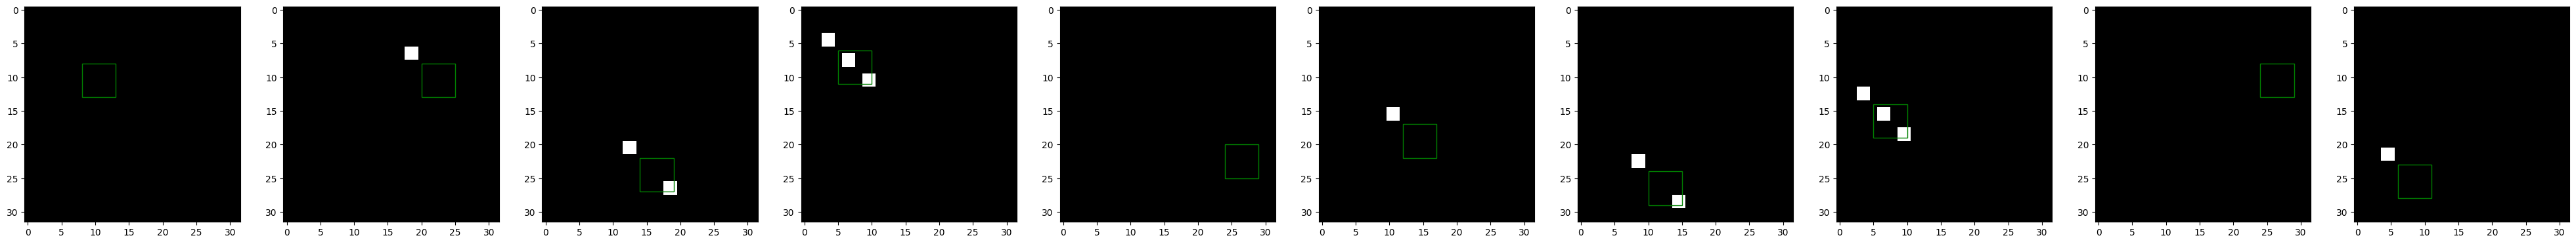

In [241]:
def plot_images_with_coordinates(images, Y_images, origin_points, n_origin_points=6, square_size=5):
    """
    Plots images with specified coordinates (origin points) marked with red squares based on their class labels.

    Parameters:
    - images: List of 2D arrays representing the images.
    - Y_images: List of labels corresponding to each image.
    - origin_points: List of origin points for each class.
    - n_origin_points: Number of origin points to consider for each class.
    - square_size: Size of the square to be plotted at each coordinate.
    """
    print("img shape", images.shape)
    print(Y_images.shape)
    
    batch_size = len(images)
    fig, ax = plt.subplots(1, batch_size, figsize=(batch_size * 5, 5))

    for i in range(batch_size):
        ax[i].imshow(images[i])
        class_label = Y_images[i, 0] if len(Y_images.shape) > 1 else Y_images[i]

        if class_label < len(origin_points):
            origins = origin_points[class_label]
            #for point in range(min(n_origin_points, len(origins))):
            #for point in range(n_origin_points):
            origin_coord = origins[i]
            if np.any(origin_coord == -1):
                continue
            x, y = origin_coord
            rect = patches.Rectangle((x - square_size//2, y - square_size//2), square_size, square_size, linewidth=1, edgecolor='g', facecolor='none')
            ax[i].add_patch(rect)

    plt.show()
print(origin_points5)
print(len(origin_points5))
print(len(origin_points5[0]))
print(len(origin_points5[0][0]))
plot_images_with_coordinates(X_test_org[:10], Y_test_org, origin_points5)


In [242]:
#find anchors on train data
counts = np.zeros((tm.number_of_clauses*tm.number_of_classes))
for image_results in X_train_all_results:
    for patch in image_results:
        patch_id = patch[0]
        counts[patch_id] += 1
anchors_id = []

# Initialize origin_points
origin_points = [[] for _ in range(tm.number_of_classes)]
# Get anchor points for each class
for Class in range(tm.number_of_classes):
    # Sort per class, args are IDs, get two most common
    #anchor_ids = Class*tm.number_of_clauses + counts[Class*tm.number_of_clauses:(Class+1)*tm.number_of_clauses].argsort()[-2:]
    anchor_ids = Class*tm.number_of_clauses + counts[Class*tm.number_of_clauses:(Class+1)*tm.number_of_clauses]
    #IDs now per class
    for anchor_id in anchor_ids: #per ID
        # Find the coordinates of the anchor patches
        for image_results in X_train_all_results:
            for result in image_results:
                if result[0] == anchor_id:
                    origin_points[Class].append(result[1:])  # Assuming result[1] has the coordinates
                else:
                    origin_points[Class].append([0,0]) 

# Now pass this to the create_dist_and_dir_map function

# Now pass this to the create_dist_and_dir_map function
if bypass_anchor_selection:
    #translate numpy array to list
    origin_points6 = [[] for _ in range(tm.number_of_classes)]
    for Class in range(tm.number_of_classes):
        for img in range(X_train.shape[0]):
                #print("ghe", tuple(coors_test_org[img, :].astype(int).tolist()))
                origin_points6[Class].append(coors_train_org[img, :].tolist())  # Assuming result[1] has the coordinates
                #origin_points5[Class].append(coors_test_org[img, :].astype(int).tolist())
        
    print("bypassed")
    encoded_patches_train = create_dist_and_dir_map(X_train_org, Y_train_org, origin_points6, 1)
else:
    encoded_patches_train = create_dist_and_dir_map(X_train_org, Y_train_org, origin_points, 2)




bypassed


In [243]:

# Create the windowed datasets
X_train = create_windowed_dataset(thermometer_encode(X_train_org), thermometer_encode(encoded_patches_train), patch_dim=patch_dim)
X_test = create_windowed_dataset(thermometer_encode(X_test_org), thermometer_encode(encoded_patches_test), patch_dim=patch_dim)



In [244]:
print(X_train.shape)

(500, 30, 30, 9216)


In [245]:
#Train the TM 2 and record results
#f = open("run_%.1f_%d_%d_%d_%d_%d.txt" % (s, clauses, T, step, visual_tokens), "w+")
logTrain = np.zeros((epochs, X_train.shape[0]), dtype=np.uint8)
logTest =  np.zeros((epochs, X_test.shape[0]),  dtype=np.uint8)

print("Training:")
training_data_labels = np.unique(Y_train)
print(training_data_labels.shape[0], "labels used:", training_data_labels)
print("Training pictures:", X_train.shape[0])

print("Testing:")
testing_data_labels = np.unique(Y_test)
print(testing_data_labels.shape[0], "labels used:", testing_data_labels)
print("Maximum achievable accuracy:", (100*(training_data_labels.shape[0]/testing_data_labels.shape[0])))
print("..adjusting") #see result_test_adj
print("Testing pictures:", X_test.shape[0])

for label in range(trained_labels.shape[0]):
        print("\nAccuracy over %d epochs:\n" % (epochs))

        tm = TMClassifier(clauses, T, s, max_included_literals=max_included_literals, patch_dim=(1,1), platform='CPU', weighted_clauses=True)
        
        for epoch in tqdm(range(epochs)):
                start_training = time()
                tm.fit(X_train, Y_train)
                stop_training = time()

                start_testing = time()
                result_test = 100*(tm.predict(X_test) == Y_test).mean()
                result_test_adj = 100*(result_test/ (100*(training_data_labels.shape[0]/testing_data_labels.shape[0])))
                logTest[epoch] = (tm.predict(X_test))*label
                stop_testing = time()

                result_train = 100*(tm.predict(X_train) == Y_train).mean()
                logTrain[epoch] = (tm.predict(X_train))*label

                #recall_and_precision(epoch)

                print("%d %d %.2f %.2f %.2f %.2f" % (label, epoch, result_test_adj, result_train, stop_training-start_training, stop_testing-start_testing))
                #print("%d %d %.2f %.2f %.2f %.2f" % (label, epoch, result_test_adj, result_train, stop_training-start_training, stop_testing-start_testing), file=f)
                #f.flush()
#f.close()



Training:
4 labels used: [0 1 2 3]
Training pictures: 500
Testing:
4 labels used: [0 1 2 3]
Maximum achievable accuracy: 100.0
..adjusting
Testing pictures: 300

Accuracy over 50 epochs:



  0%|          | 0/50 [00:00<?, ?it/s]

2023-12-18 17:21:49,284 - tmu.models.classification.base_classification - DEBUG - Initializing clause bank....


  2%|▏         | 1/50 [02:12<1:48:03, 132.31s/it]

0 0 34.00 30.60 21.48 41.26


  4%|▍         | 2/50 [04:07<1:37:43, 122.16s/it]

0 1 29.33 33.00 4.79 40.69


  6%|▌         | 3/50 [06:02<1:33:15, 119.04s/it]

0 2 38.00 45.00 4.64 40.96


  8%|▊         | 4/50 [07:58<1:30:11, 117.64s/it]

0 3 47.67 48.80 4.63 41.05


 10%|█         | 5/50 [09:53<1:27:35, 116.80s/it]

0 4 48.33 48.80 4.56 40.98


 12%|█▏        | 6/50 [11:48<1:25:18, 116.33s/it]

0 5 46.00 50.40 4.56 41.02


 14%|█▍        | 7/50 [13:43<1:23:01, 115.85s/it]

0 6 46.67 51.00 4.53 40.68


 16%|█▌        | 8/50 [15:38<1:20:53, 115.57s/it]

0 7 43.00 51.60 4.54 40.71


 18%|█▊        | 9/50 [17:33<1:18:52, 115.44s/it]

0 8 46.67 54.40 4.56 40.91


 20%|██        | 10/50 [19:28<1:16:50, 115.27s/it]

0 9 48.00 54.20 4.46 40.73


 22%|██▏       | 11/50 [21:23<1:14:51, 115.17s/it]

0 10 48.67 53.40 4.50 40.73


 24%|██▍       | 12/50 [23:18<1:12:56, 115.16s/it]

0 11 47.00 54.40 4.47 41.11


 26%|██▌       | 13/50 [25:13<1:10:59, 115.12s/it]

0 12 49.00 52.60 4.39 40.83


 28%|██▊       | 14/50 [27:09<1:09:04, 115.12s/it]

0 13 45.00 51.20 4.58 40.86


 30%|███       | 15/50 [29:03<1:07:06, 115.05s/it]

0 14 51.00 53.40 4.46 40.75


 32%|███▏      | 16/50 [30:58<1:05:07, 114.94s/it]

0 15 46.33 53.20 4.40 40.65


 34%|███▍      | 17/50 [32:53<1:03:11, 114.90s/it]

0 16 49.33 55.20 4.40 40.73


 36%|███▌      | 18/50 [34:48<1:01:15, 114.87s/it]

0 17 51.00 53.60 4.43 40.59


 38%|███▊      | 19/50 [36:43<59:21, 114.87s/it]  

0 18 49.33 57.00 4.44 40.73


 40%|████      | 20/50 [38:37<57:25, 114.87s/it]

0 19 47.33 54.60 4.40 40.78


 42%|████▏     | 21/50 [40:32<55:30, 114.85s/it]

0 20 49.00 54.40 4.41 40.65


 44%|████▍     | 22/50 [42:27<53:38, 114.96s/it]

0 21 47.33 54.80 4.46 40.79


 46%|████▌     | 23/50 [44:23<51:45, 115.01s/it]

0 22 44.67 52.40 4.58 40.78


 48%|████▊     | 24/50 [46:17<49:46, 114.88s/it]

0 23 47.67 55.00 4.47 40.50


 50%|█████     | 25/50 [48:12<47:48, 114.72s/it]

0 24 53.33 54.60 4.43 40.54


 52%|█████▏    | 26/50 [50:06<45:49, 114.56s/it]

0 25 49.00 54.20 4.39 40.48


 54%|█████▍    | 27/50 [52:00<43:51, 114.42s/it]

0 26 49.00 55.80 4.40 40.32


 56%|█████▌    | 28/50 [53:54<41:54, 114.27s/it]

0 27 51.00 56.20 4.40 40.24


 58%|█████▊    | 29/50 [55:48<39:59, 114.27s/it]

0 28 54.33 56.00 4.38 40.58


 60%|██████    | 30/50 [57:42<38:03, 114.19s/it]

0 29 51.00 56.20 4.43 40.26


 62%|██████▏   | 31/50 [59:37<36:12, 114.33s/it]

0 30 48.67 55.20 4.39 40.49


 64%|██████▍   | 32/50 [1:01:33<34:27, 114.84s/it]

0 31 52.00 54.60 4.65 41.31


 66%|██████▌   | 33/50 [1:03:28<32:34, 114.99s/it]

0 32 52.00 56.20 4.70 41.09


 68%|██████▊   | 34/50 [1:05:22<30:37, 114.82s/it]

0 33 46.67 56.80 4.49 40.40


 70%|███████   | 35/50 [1:07:17<28:41, 114.76s/it]

0 34 52.67 55.60 4.45 40.63


 72%|███████▏  | 36/50 [1:09:11<26:44, 114.64s/it]

0 35 50.67 56.80 4.43 40.52


 74%|███████▍  | 37/50 [1:11:06<24:49, 114.60s/it]

0 36 48.67 55.80 4.38 40.68


 76%|███████▌  | 38/50 [1:13:00<22:54, 114.54s/it]

0 37 49.67 56.20 4.41 40.53


 78%|███████▊  | 39/50 [1:14:55<21:00, 114.55s/it]

0 38 52.67 57.80 4.39 40.75


 80%|████████  | 40/50 [1:16:49<19:04, 114.44s/it]

0 39 48.00 56.40 4.38 40.47


 82%|████████▏ | 41/50 [1:18:44<17:10, 114.55s/it]

0 40 50.00 56.20 4.42 40.37


 84%|████████▍ | 42/50 [1:20:40<15:19, 114.95s/it]

0 41 50.67 56.60 4.84 41.00


 86%|████████▌ | 43/50 [1:22:35<13:24, 114.93s/it]

0 42 53.33 56.60 4.68 40.67


 88%|████████▊ | 44/50 [1:24:29<11:28, 114.77s/it]

0 43 53.00 54.60 4.42 40.68


 90%|█████████ | 45/50 [1:26:20<09:28, 113.71s/it]

0 44 48.00 55.40 4.20 39.17


 92%|█████████▏| 46/50 [1:28:11<07:31, 112.82s/it]

0 45 51.33 54.40 4.06 38.92


 94%|█████████▍| 47/50 [1:30:03<05:37, 112.63s/it]

0 46 47.33 56.60 4.09 38.95


 96%|█████████▌| 48/50 [1:31:58<03:46, 113.40s/it]

0 47 49.33 56.60 4.27 40.45


 98%|█████████▊| 49/50 [1:33:50<01:52, 112.76s/it]

0 48 49.67 56.20 4.07 39.33


100%|██████████| 50/50 [1:35:41<00:00, 114.82s/it]


0 49 50.67 54.80 4.13 39.00

Accuracy over 50 epochs:



  0%|          | 0/50 [00:00<?, ?it/s]

2023-12-18 18:57:30,485 - tmu.models.classification.base_classification - DEBUG - Initializing clause bank....


  2%|▏         | 1/50 [02:05<1:42:48, 125.89s/it]

1 0 31.00 30.20 19.09 39.32


  4%|▍         | 2/50 [03:57<1:33:56, 117.43s/it]

1 1 38.00 34.80 4.31 39.27


2023-12-18 10:32:52,861 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x2a2ef35e0>


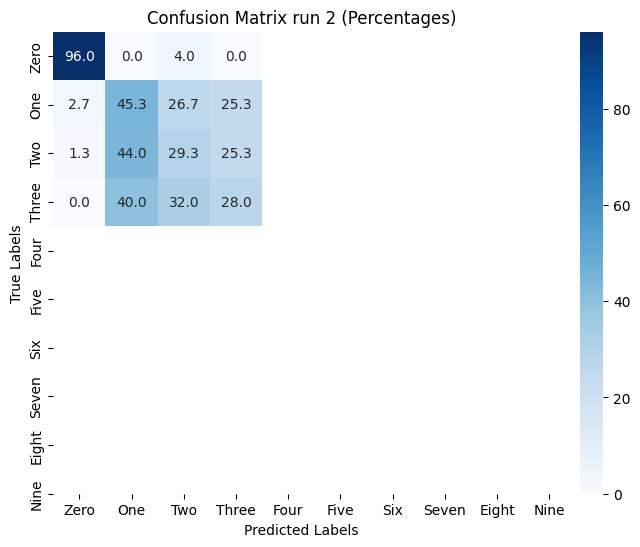

In [ ]:
#Confusion Matrix
conf_matrix2 = confusion_matrix(Y_test, tm.predict(X_test))
# Calculate percentages
conf_matrix_percent2 = conf_matrix2 / conf_matrix2.sum(axis=1, keepdims=True) * 100
conf_matrix_percent2 = np.nan_to_num(conf_matrix_percent2, 0)  # Replace NaNs with 0

# Plot the confusion matrix with percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent2, annot=True, fmt=".1f", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix run 2 (Percentages)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


2023-12-18 10:32:53,020 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x2a401d0f0>


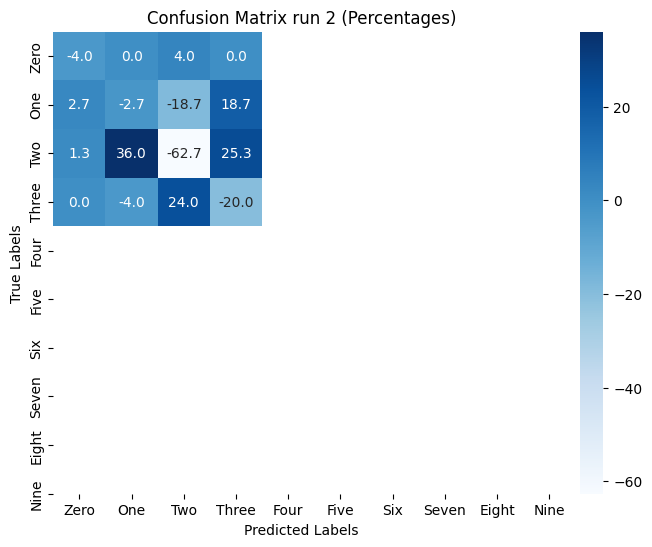

In [ ]:
#Confusion Matrix

# Plot the confusion matrix with percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent2-conf_matrix_percent1, annot=True, fmt=".1f", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix run 2 (Percentages)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
